In [1]:
from scipy import linalg
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Image
from math import (log,ceil,floor)
from scipy.fft import fft, ifft
from scipy.linalg import dft, inv, expm, norm
from numpy.linalg import matrix_power
import networkx as nx
from qiskit import( ClassicalRegister,
        QuantumRegister,
        QuantumCircuit,
        execute,
        Aer,
        IBMQ,
        transpile)
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import( plot_histogram,
                        plot_state_city,
                        plot_gate_map, 
                        plot_circuit_layout)
from qiskit.circuit.library import QFT
style = {'figwidth':9,'fontsize':15,'subfontsize':12}
styleWide = {'figwidth':25,'fontsize':17,'subfontsize':14}

plt.rcParams['figure.figsize'] = 10,8
matplotlib.rcParams.update({'font.size' : 15})

import warnings
warnings.filterwarnings("ignore")

In [2]:
def circulantAdjacency(n,v):
    iv = list(range(0,n))
    av = list(range(0,n-1))
    C = np.zeros([n,n])
    for z in range(n):
        C[z,0] = v[iv[z]]    
    for x in range(1,n):
        av = iv[0:-1]
        iv[0] = iv[-1]
        iv[1::] = av
        for y in range(0,n):
            C[y,x] = v[iv[y]]
    return C

n_cycle = 8
cCycle = [0,1] + [0 for x in range(n_cycle-3)] + [1] 
ACycle = circulantAdjacency(n_cycle,cCycle)
GCycle = nx.from_numpy_matrix(np.array(ACycle))  

n_complete = 8
cComplete = [0] + [1 for x in range(n_complete-1)] 
A = circulantAdjacency(n_complete,cComplete)
GComplete = nx.from_numpy_matrix(np.array(A))  


$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
$
<center> <h1>Quantum Random Walks</h1> </center>
<center> <h3>by Jaime Pereira Santos</h3> </center>

Jaime Santos - Aluno de doutoramento em Informatica, e hoje venho-vos apresentar o trabalho desenvolvido durante a minha dissertacao de mestrado, orientada pelo

Prof Luis Barbosa - Uminho

Prof Bruno Chagas - ICHEC - Irish Centre for High-End Computing

## Structure of the presentation
\begin{enumerate}
\item Classical Random Walk
\item Discrete-time Coined Quantum Walk
    \begin{enumerate}
        \item Simulation
        \item Qiskit implementation
     \end{enumerate}

\item Continuous-time Quantum Walk
    \begin{enumerate}
        \item Simulation
        \item Qiskit implementation
     \end{enumerate}

\item Searching Problems
    \begin{enumerate}
        \item Grover's Algorithm
        \item Continuous-time Quantum Walk
     \end{enumerate}
\end{enumerate}


Começamos por ver um breve exemplo de uma caminhada classica para ganhar alguma intuiçao sobre este tipo de algoritmos, e para perceber o contraste entre o caso classico e quantico.

De seguida vemos o caso de uma quantum walk discreta com moeda, a sua simulaçao em python e implementaçao em qiskit.
Fazemos o mesmo para o modelo continuo no tempo.

Por fim fazemos uma revisao do Grover, e de seguida uma breve descrição do problema de busca com a caminhada continua.

<center> <h2>Classical Random Walk</h2> </center>

In [3]:
def classicalWalk(nExp,steps):
    positions = []
    for x in range(ne):
        k = 0
        for y in range(steps):
            a = randint(0,1)
            k+=(-1)**a
        positions.append(k)
    return positions

The term \textit{random walk}, firstly introduced by \cite{kpearson1905}, is classically defined as a stochastic process that models the path a walker would take through a mathematical space, where each step made by the walker is random. 

The term usually refers to a special case of Markov chains, which are stochastic processes that describe a sequence of events, where the probability of transitioning from one state to another depends only on the state of the previous event.

This is a useful framework, since it can be used to explain the behavior of systems across many fields, from the Brownian movement of particles moving through a gas, to the price of a fluctuating stock as shown by \cite{cootner67}.

Uma caminhada classica, primeiramente definida pelo Karl Pearson, é um processo estocastico que descreve o trajeto feito por um caminhante atraves de um certo espaço matematico, cujos passos sao dados aleatoriamente.

Esta estrutura tem utilidade em diversas areas, como física, quimica, biologia, enconomia etc., visto que podem ser utilizadas para modelar desde o movimente Browniano de particulas até ao preço flutante de açoes, como demonstrado no trabalho de Cootner.

One specific instance of this model is when a walker, who's standing on a line of discretely numbered integers, tosses a coin and goes left or right depending if the coin rolled heads or tails. \par
Starting from $0$, this walker moves to $x = +1$ or $ x = -1$ with $\frac{1}{2}$ probability after the first toss. On the second toss, the walker could be on $x =\pm 2$ with $\frac{1}{4}$ probability each, and on $x = 0$ with $\frac{1}{2}$. 

Continuing this trend will result in a normal probability distribution around the origin.

In [4]:
%%HTML
<center>
<video width="810" height="570" controls>
  <source src="ClassicalWalk.mp4" type="video/mp4">
</video>

Vamos estudar o caso onde um caminhante se encontra cima de uma linha discretamente numerada por inteiros, e a decisao de dar um passo para a esquerda ou direita resulta do lançamento de uma moeda.

Começando na posiçao 0, apos o primeiro lançamento, o caminhante pode estar na posiçao 1 ou -1 com probabilidade 1/2.

No lançamento seguinte, este avança para a posiçao 2 ou -2 com probabilidade 1/4 cada, ou recua para 0 com probabilidade 1/2.

Lançando a moeda multiplas vezes, o resultado vai aproximar-se de uma distribuiçao normal.

Podemos ver que à medida que mais passos sao dados mais posiçoes sao possiveis de alcançar. 

No entanto, mesmo depois de 500 passos, o caminhante vai ser encontrado muito perto da origem.

<center> <h2> Coined Quantum Random Walk </h2> </center>

Agora que temos uma ideia de como este algoritmo funciona, vamos considerar o caso em que tanto o caminhante como a moeda sao sistemas quanticos.

In [5]:
#Coined Simulation Functions
def coins(Matrix):
    if Matrix == "H":
        coin = np.array([[1/np.sqrt(2) , 1/np.sqrt(2)],[1/np.sqrt(2) , -1/np.sqrt(2)]])
    elif Matrix == "X":
        coin = np.array([0,1],[1,0])
    return coin

def init_state(N,P,CoinState):
    initstate = np.zeros((N,1))
    initstate[P][0] = 1
    g = np.kron(CoinState,initstate)
    return g

def init_coin(init):
    if init == "0":
        psi0 = np.array([[1],[0]])
    if init == "1":
        psi0 = np.array([[0],[1]])
    if init == "01":
        psi0 = np.array([[1/np.sqrt(2)],[(1*1j)/np.sqrt(2)]])
    return psi0

def walk_op(N,state0,state1):
    c00= np.outer(state0,state0)
    c11= np.outer(state1,state1)
    ShiftPlus = np.roll(np.eye(N),1,axis=0)
    ShiftMinus = np.roll(np.eye(N),-1,axis=0)
    Shift = np.kron(c00,ShiftPlus) + np.kron(c11,ShiftMinus) 
    return Shift

def CU_op(coin, shift,N):
    U = shift.dot(np.kron(coin,np.eye(N)))
    return U

def final_state(U,psi0,steps):
    for t in range(0,steps):
        psi0=U.dot(psi0)
    return psi0

def prob_vec(psiN,N):
    probs = np.zeros((N,1))
    for x in range(N):
        probs[x]=psiN[x]*np.conjugate(psiN[x]) + psiN[N+x]*np.conjugate(psiN[N+x]) #duvida aqui
    return probs

def cqwalk(N,steps,coinstate):
    P = int((N+1)/2)
    state0 = np.array([1,0])
    state1 = np.array([0,1])
    Coin = coins("H")
    shift= walk_op(N,state0,state1)
    U = CU_op(Coin,shift,N)
    psi0 = init_state(N,P,coinstate)
    psiN = final_state(U,psi0,steps)
    probvec = prob_vec(psiN,N)
    return probvec

The quantum analogue of the random walk was firstly developed by \cite{aharonov1993}, where they defined the \textit{coined quantum random walk}.  This model consists of a walker and a coin that determines the movement of the walker, which are both quantum systems where time is a discrete variable dictated by the successive quantum coin flips and shifts in position.

\begin{itemize}
\item \cite{nayak2000} and \cite{aharonov2002} - First analyses of the quantum walk on a line;
\item \cite{inui2003} - Behavior of the walk on grids;
\item \cite{shenvi2002} - First algorithmic applications (search problem);
\item \cite{lovett2010} - Showed that discrete-time quantum walks can be used for universal quantum computation.
\end{itemize}


Primeiramente desenvolvido pelo Ahronov e colegas, o modelo discreto deriva a sua noçao de tempo pelos sucessivos lançamentos da moeda e mudanças de posiçao, que vao ser posteriormente definidos como operadores distintos.

Podemos ver aqui as primeiras analises da dinamica em diferentes estruturas. 

Temos tambem a implementaçao da caminhada quantica como um problema de busca, e mais tarde um resultado que demonstra que este modelo pode ser usado para computaçao universal.


The space of our coined quantum walk (CQW) is composed by the coin $\mathcal{H_C}$ and walker spaces $\mathcal{H_W}$, therefore

\begin{equation}
\mathcal{H} = \mathcal{H_C} \otimes \mathcal{H_W}
\end{equation}

The principles of the walk are the same as in the classical case; if the coin is tossed and rolls "heads", for example, the system transitions to position  $\ket{x+1}$, otherwise it advances to  $\ket{x-1}$. 

However, since the system is allowed to be in a superposition of states, it will interfere constructively and destructively with itself, producing a behavior unlike anything in the classical quantum walk case.

O espaço de hilbert da caminhada vai ser a combinaçao tensorial do espaço da moeda e do caminhante.

Os principios da caminhada sao parecidos ao da classica, sendo os estados agora descritos com notaçao de Dirac. 

A moeda é lançada e o caminhante avança para a esquerda ou direita.

No entanto, como o sistema pode estar numa sobreposiçao de estados, vai existir interferencia construtiva e destrutiva, levando a uma distribuiçao completamente diferente do caso classico.

Considering a quantum random walk on a cyclic graph, where each vertex only has 2 neighbors

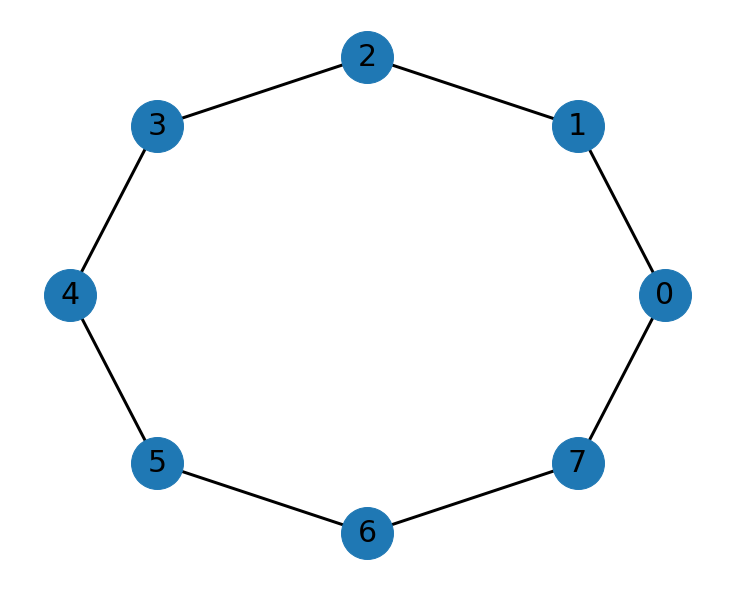

In [6]:
nx.draw_circular(GCycle, with_labels = True,node_size=2700,width=3,font_size=30) 

Como estamos a considerar o caso de uma caminhada num ciclo, cada vertice vai ter só e apenas 2 vizinhos.

The coin will be a single qubit unitary operator defined as

\begin{equation}
        \begin{cases}
                C\ket{0}\ket{x} = a\ket{0}\ket{x} + b\ket{1}\ket{x}\\
                C\ket{1}\ket{x} = c\ket{0}\ket{x} + d\ket{1}\ket{x},
        \end{cases}
\end{equation}

where  a, b, c and d are the amplitudes associated with each outcome of the coin toss.

In this example, a balanced coined will be considered, therefore it will simply be the Hadamard operator

\begin{equation}
        C_H = \begin{pmatrix} 
                a & c\\
                b & d
            \end{pmatrix}
            =\frac{1}{\sqrt{2}} \begin{pmatrix}
                                        1 & 1\\
                                        1 & -1
                               \end{pmatrix},
\end{equation}


In [7]:
coin = np.array([[1/np.sqrt(2) , 1/np.sqrt(2)],
              [1/np.sqrt(2), -1/np.sqrt(2)]
             ])
print(coin) 

[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]


O que quer dizer que a moeda necessita apenas de dois resultados. 

Se os vertices tivessem mais vizinhos, poderiamos usar um dado por exemplo. 

Vamos entao associar cada resultado da moeda a um estado da base computacional.

Neste exemplo vamos considerar uma moeda balanceada, visto que queremos que cada face da moeda apareça com a mesma probabilidade (ou amplitude).

Para este efeito usamos o operador de Hadamard, que terá este aspeto utilizando o Numpy.

We can describe the shift operator as

\begin{eqnarray}
    S\ket{0}\ket{x} &=& \ket{0}\ket{x+1}\\
    S\ket{1}\ket{x} &=& \ket{1}\ket{x-1} \nonumber
\end{eqnarray}

and S in the computational basis has the format

\begin{equation}
        S = \ket{0}\bra{0} \otimes \sum_{x} \ket{x+1}\bra{x}+ \ket{1}\bra{1} \otimes \sum_{x} \ket{x-1}\bra{x}
\end{equation}

In [8]:
N = 5
c00 = np.outer(np.array([1,0]),np.array([1,0]))
c11 = np.outer(np.array([0,1]),np.array([0,1])) 
  
ShiftPlus = np.roll(np.eye(N),1,axis=0)
ShiftMinus = np.roll(np.eye(N),-1,axis=0)

shift= np.kron(c00,ShiftPlus) + np.kron(c11,ShiftMinus) 
print(shift)

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


O operador shift vai incrementar a posiçao do caminhante caso o resultado da moeda seja 0, e decrementar caso seja 1. 

Esta escolha é arbitraria, mas terá impacto na distribuiçao final.

Podemos reescrever este operador na sua forma matricial, em que os produtos externos sao controladores que ditam se incrementamos ou decrementamos o estado.

Vemos que o bloco superior esquerdo da matriz corresponde ao caso da moeda ser 0, em que a coluna dita qual vertice estamos a considerar, e a linha qual vertice será o próximo. 

Por exemplo vemos que temos um 1 na coluna 5 linha 0, o que quer dizer que o vertice 5 incrementa para o 0 quando a moeda é 0. 

O analogo acontece para o bloco inferior direito, correspondente à face 1 da moeda.


It follows that the operator that describes the dynamics of the quantum walk will be given by

\begin{equation}
       U = S(C \otimes I_N) \quad \longrightarrow \quad S(C_H\otimes I)
\end{equation}

O operador de evoluçao pode ser entao descrito como a aplicaçao da moeda seguida do shift. 

Fazemos o tensorial da moeda com a identidade de modo a garantir que ambos os operadores tenham a mesma dimensao.

Divindindo a matriz a meio, vemos que do lado esquerdo temos o resultado de quando a moeda dá zero, e do lado direito o resultado de quando a moeda dá 1. 

O bloco superior esquerdo corresponde ao lançamento anterior ter sido 0 e o atual 0, e o bloco inferior direito quando o tanto o lançamento anterior como o atual sao 1, o que quer dizer que quando aplicamos a operaçao Hadamard, o sinal é invertido.


In [9]:
UCoined = shift.dot(np.kron(coin,np.eye(N))) 
print(UCoined.round(3))

[[ 0.     0.     0.     0.     0.707  0.     0.     0.     0.     0.707]
 [ 0.707  0.     0.     0.     0.     0.707  0.     0.     0.     0.   ]
 [ 0.     0.707  0.     0.     0.     0.     0.707  0.     0.     0.   ]
 [ 0.     0.     0.707  0.     0.     0.     0.     0.707  0.     0.   ]
 [ 0.     0.     0.     0.707  0.     0.     0.     0.     0.707  0.   ]
 [ 0.     0.707  0.     0.     0.     0.    -0.707  0.     0.     0.   ]
 [ 0.     0.     0.707  0.     0.     0.     0.    -0.707  0.     0.   ]
 [ 0.     0.     0.     0.707  0.     0.     0.     0.    -0.707  0.   ]
 [ 0.     0.     0.     0.     0.707  0.     0.     0.     0.    -0.707]
 [ 0.707  0.     0.     0.     0.    -0.707  0.     0.     0.     0.   ]]


Consider a quantum system located at $\ket{x = 0}$ with coin state  $\ket{0}$, for  $t=0$. It's state will be described by

\begin{equation}
        \ket{\psi(0)} = \ket{0}\ket{x=0}.
        \label{eq:coinedQWInitCond0}
\end{equation}

Applying the unitary evolution operator $t$ times

\begin{equation}
      \ket{\Psi(0)}\xrightarrow[]{\text{$U$}}\ket{\Psi(1)}\xrightarrow[]{\text{$U$}}\ket{\Psi(2)}\xrightarrow[]{\text{$U$}} (...) \xrightarrow[]{\text{$U$}}\ket{\Psi(t)}
\end{equation}

will result in state

\begin{equation}
	\ket{\Psi(t)}=U^{t}\ket{\Psi(0)},
\end{equation}

In [10]:
steps = 1
psi0 = init_state(N,int(N/2)+1,init_coin('0')) # Starts at x = 3
psiInit = psi0
psiT = psi0
for t in range(0,steps):
    psi0 = UCoined.dot(psi0)
    psiT = psi0
    
for b,d, c in zip(list(range(2*N)),psiInit, psiT):
    print(np.mod(b,N),d,c)

0 [0.] [0.]
1 [0.] [0.]
2 [0.] [0.]
3 [1.] [0.]
4 [0.] [0.70710678]
0 [0.] [0.]
1 [0.] [0.]
2 [0.] [0.70710678]
3 [0.] [0.]
4 [0.] [0.]


Consideramos agora o estado inicial em que ambos o caminhante e moeda estao no 0.

Aplicar o operador uma vez resulta numa iteraçao do algoritmo, e o estado final será descrito por multiplas iteraçoes.

Neste caso definimos o nosso 0 na posiçao 3 desta matriz, para ficar no meio do grafo, e vemos que as primeiras linhas correspondem ao caso do lançamento ter sido 0, visto que incrementamos do estado 3 para o 4. 

O mesmo acontece para as segundas linhas, que decrementam do 3 para o 2 quando o resultado da moeda é 1.

The probability distribution is then obtained by the Born rule
 
\begin{equation}
    p(\ket{\psi(t)}) = \lvert \ket{\psi(t)}  \rvert^2
\end{equation}


In [11]:
probs = np.zeros((N,1))
for x in range(N):
        probs[x] = abs(psiT[x])**2 + abs(psiT[N+x])**2 
print(probs)   

[[0. ]
 [0. ]
 [0.5]
 [0. ]
 [0.5]]


Para obter a distribuiçao de probabilidades, vamos reduzir o espaço da caminhada, visto que ja nao nos interessa saber qual face da moeda contribuiu para cada transiçao.

Fazemos entao uso da regra de Borne. Podemos ver que temos 50% de estar tanto no 2 como no 4.

Putting it all together, the _cqwalk_ function (available in this notebook) returns a probability distribution ready to be plotted.\par
For this example we consider a CQW, after $100$ steps, on cyclic graph with 200 vertices.

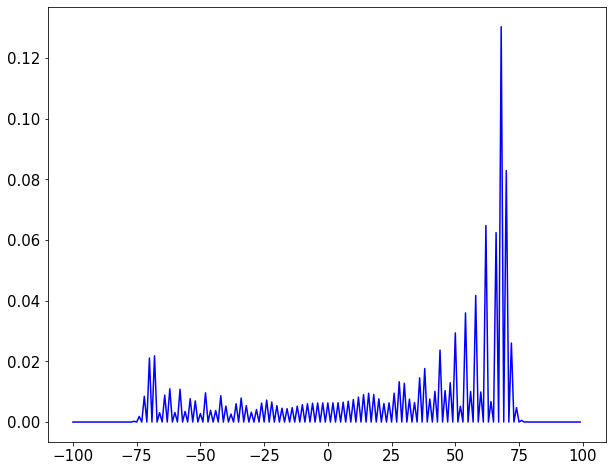

In [12]:
N = 200
steps = 100

initcondcoin0 = init_coin('0')

qw0 = cqwalk(N,steps,initcondcoin0) 

plt.plot(np.arange(-N/2,N/2),qw0 ,'b')
plt.show()

The Hadamard operator flips the sign of state $\ket{1}$, hence more terms are canceled when the coin state is $\ket{1}$. Since $\ket{0}$ was defined to _increment_ state $\ket{x}$, then it is obvious why there is a higher probability of finding the walker in the right-side of the graph.

Fazendo isto para um caso maior vemos que, ao contrario da caminhada classica, é mais provavel encontrar o caminhante longe da origem, no lado direito do grafo. 

Este deslize para a direita acontece porque definimos o estado 0 da moeda para ser responsavel pelo incremento. 

Apesar da moeda de Hadamard ser balanceada, esta inverte o sinal quando aplicada ao estado 1, levando a mais cancelamentos de estados que correspondem à face 1 da moeda.

Following this logic, it would be expected that an initial condition

\begin{equation}
        \ket{\Psi(0)} = \ket{1}\ket{x=0},
        \label{eq:coinedQWInitCond1}
\end{equation}

would result in more cancellations of terms when the coin state is $\ket{0}$, resulting in a drift towards the left-side.

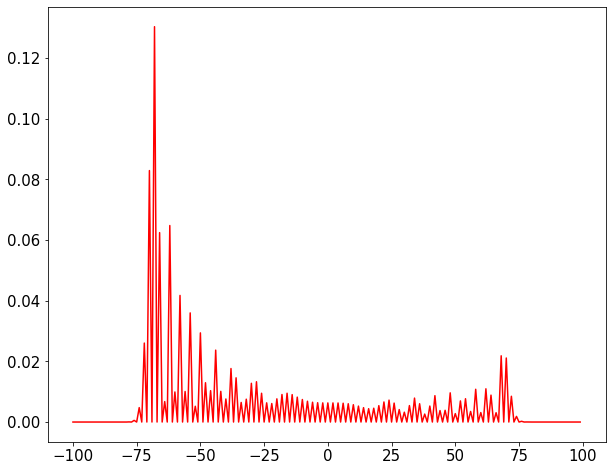

In [13]:
N = 200
steps = 100

init1 = '1'
initcondcoin1 = init_coin(init1)
qw1 = cqwalk(N,steps,initcondcoin1)

plt.plot(np.arange(-N/2,N/2),qw1 ,'r')
plt.show()

Seguindo esta logica, mudar o estado inicial da moeda para 1 resulta no aparecimento de mais termos negativos do que positivos, levando a caminhada para a esquerda.

In [14]:
%%HTML
<center>
<video width="810" height="570" controls>
  <source src="QuantumWalkAsym.mp4" type="video/mp4">
</video>

Podemos ver o comportamento da walk nesta animaçao. 

Reparem que, como estamos a tratar de um grafo ciclico, o pico maior irá desparecer da esquerda e aparecer na direita, cruzando-se com o pico menor, existindo interferencia.

Deixando a caminhada continuar a sua evoluçao, vemos que a probabilidade começa a ficar mais homogenea, chamando-se a isto tempo de mistura.

In order to obtain a symmetrical distribution, the initial state of the coin must be a superposition. However, in order to not cancel    terms before the calculation of the probability distribution, one must multiply state $\ket{1}$ with the imaginary unit $i$

\begin{equation}
        \ket{\Psi(0)} = \frac{\ket{0}+i\ket{1}}{\sqrt{2}}\ket{x=0}.
        \label{eq:12}
\end{equation}


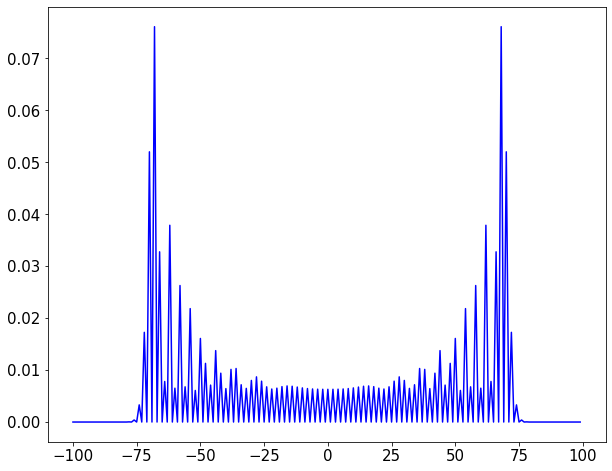

In [31]:
N = 200
steps = 100

init01 = '01'
initcondcoin01 = init_coin(init01)
qw01 = cqwalk(N,steps,initcondcoin01)

plt.plot(np.arange(-N/2,N/2),qw01 ,'b')
plt.show()

Para obter uma distribuiçao simétrica, sobrepomos as condiçoes iniciais anteriores, multiplicando o estado 1 por i para os termos nao se cancelarem antes do calculo da distribuiçao de probabilidades.

A distribuiçao está espalhada entre - t/sqrt(2) e t/sqrt(2), com os picos mais ou menos nas extremidades. 

Isto quer dizer que após t passos, é mais provavel encontrar o caminhante longe da origem, tanto para a direita como para a esquerda, o que nunca se observa no caso classico com movimento difuso.

In [16]:
%%HTML
<center>
<video width="810" height="570" controls>
  <source src="CoinedQuantumWalk500.mp4" type="video/mp4">
</video>

Podemos ver na animação que agora os dois picos vão se afastar da origem simétricamente circulando o grafo, evoluindo até a homogeneizaçao.

The probability distribution is now symmetric and it is spread over the range $[-\frac{t}{\sqrt{2}},\frac{t}{\sqrt{2}}]$ with peaks around $x \approx \pm \frac{t}{\sqrt{2}}$. This means that if the position of the walker was measured at the end, it would be equally probable to find him either in the left side or the right side of the graph, which is not possible in a classical diffusive motion.


This tendency for the walker to be more likely found away from the origin is called \textit{ballistic} motion, since its standard deviation is

\begin{equation}
	\sigma(t) \approx 0.54t ,
\end{equation}

as was shown by \cite{REN1}.

In contrast, the standard deviation of the classical random walk grows with $\sqrt{t}$, meaning that a quantum walker moves away from the origin quadratically faster than a classical walker. This has varied applications

\begin{itemize}
\item \cite{childs2002} - Exponentially faster hitting times in certain graphs;

\item \cite{ambainis2003} - Advantages in element distinctness problems;

\item \cite{childs2004} - Avantages in spatial search problems.
\end{itemize}


Este comportamento de se encontrar mais longe da origem é chamado movimento balistico, visto que o desvio padrao varia linearmente no tempo.

Em contraste, na caminhada classica, o desvio padrao varia com sqrt(t), o que quer dizer que o caminhante afasta-se quadraticamente mais rapido numa caminhada quantica. 

Isto tem algumas vantagens como por exemplo

1. Tempos de alcance mais rapidos, melhorando problemas de travessia de grafos.

2. Em Problemas de distinçao de elementos, que é descobrir se todos os elementos de uma list sao distintos.

3. Problemas de busca do genero do Grover.


<center> <h2> Qiskit Implementation </h2> </center>

Passamos agora para a criação de circuitos no Qiskit para este algoritmo.

In [17]:
def simul(qc,stateVec,shots):
    if stateVec:
        backend = Aer.get_backend('statevector_simulator')
        result = execute(qc,backend,shots=shots).result().get_statevector(qc,decimals=3)
    else:
        backend = Aer.get_backend('qasm_simulator')
        result = execute(qc
                         ,backend,shots=3000).result().get_counts()
    return result

def baseResultDict(n,decimal):
    "Retuns a dictionary composed of a range of N keys converted to binary."
    baseDict = {}
    if decimal:
        for decNumber in range(2**n):
            dec = decNumber 
            baseDict[dec] = 0
    else:
        for decNumber in range(2**n):
            decToBin = bin(decNumber)[2:].zfill(ceil(log(2**n,2)))
            baseDict[str(decToBin)] = 0  
    return baseDict

def normalizedResultDict(baseDict,qiskitDict):
    "Returns the result of merging qiskit produced dictionaries with dictionaries produced from multBinResultDict for graph formatting reasons."
    new_d1 = baseDict
    new_d2= qiskitDict
    normalizedResultDict = {**new_d1,**new_d2}
    return normalizedResultDict

def resultsSim(N,circ,shots,Decimal):
    "Returns the dictionary produced by QASM simulator with the MSB changed to convention, and values (previously frequencies) converted to probabilities."
    result = simul(circ,False,shots)
    baseDict = baseResultDict(N,Decimal)
    if Decimal:
        correctedResultAux = { int(k,2) : v/shots for k, v in result.items()}
    else:
        correctedResultAux = { k : v/shots for k, v in result.items()}
    correctedResult = normalizedResultDict(baseDict,correctedResultAux)
    return correctedResult

def c_increment(n):
    c_inc = QuantumCircuit(n)
    controls = [x for x in range(n-1)]
    for p in range(n-1):
        c_inc.mcx(controls,controls[-1] + 1)
        controls.pop()
    c_inc.x(0)
    c_inc = c_inc.to_gate()
    c_inc.name = '    INC    '
    c_inc = c_inc.control()
    return c_inc
    
def c_decrement(n):
    c_dec = QuantumCircuit(n)
    controls = [x for x in range(n-1)]
    c_dec.x(controls)
    for p in range(n-2):
        c_dec.mcx(controls,controls[-1] + 1)
        c_dec.x(controls[-1])
        controls.pop()   
    c_dec.cx(0,1)
    c_dec = c_dec.to_gate()
    c_dec.name = '    DEC    '
    c_dec = c_dec.control()
    return c_dec

def initialCond(qc,string,N):
    for x in range(N):
        if string[x] == '1':
            qc.x(x)
    return qc


def runCoinedWalk(n,steps,initString):
    qw_qc = QuantumCircuit(n+1,n)
    u_inc = c_increment(n)
    u_dec = c_decrement(n)
    #--- Initial Condition
    qw_qc = initialCond(qw_qc,initString,n)
    qw_qc.barrier()
    #--- Diffusion
    for t in range(steps):
        qw_qc.h(n)
        qw_qc.x(n)
        qw_qc.append(u_inc, [n]+list(range(0, n)))
        qw_qc.x(n)
        qw_qc.append(u_dec, [n]+list(range(0, n)))
        qw_qc.barrier()
    qw_qc.measure(range(n),range(n))
    return qw_qc

def runCoinedWalkSup(n,steps,initString):
    qw_qc = QuantumCircuit(n+1,n)
    u_inc = c_increment(n)
    u_dec = c_decrement(n)
    #--- Initial Condition
    qw_qc = initialCond(qw_qc,initString,n)
    qw_qc.h(n)
    qw_qc.s(n)
    qw_qc.barrier()
    #--- Diffusion
    for t in range(steps):
        qw_qc.h(n)
        qw_qc.x(n)
        qw_qc.append(u_inc, [n]+list(range(0, n)))
        qw_qc.x(n)
        qw_qc.append(u_dec, [n]+list(range(0, n)))
        qw_qc.barrier()
    qw_qc.measure(range(n),range(n))
    return qw_qc

Now, the focus is to study a quantum circuit based on the work presented by \cite{douglaswang07}.\par
This approach relies on a set of operations that shift the state of the walker by $+1$ or $-1$, each with a probability associated with the chosen coin.

<center>
<img src="dwcircuit.png" width="1000" height="800"/>

A base para esta implementação segue a abordagem presente no trabalho do Douglas e Wang. 

Neste paper, está presente a construçao de um conjunto de operaçoes que incrementam ou decrementam o estado em funçao da moeda.

Na verdade, os controlos estao invertidos em relaçao ao artigo, de modo a estarem em conformidade com a simulaçao.

The increment and decrement operations will be, respectivetly

<center>
<img src="dwIncDec.png" width="1300" height="1200"/>

The generalized CNOT gates act on the node states as a cyclic permutator, where each vertex is mapped to an adjacent state. This can be seen as the walker moving left or right, in the unidimensional graph example.

For a graph with $8$ nodes, for example, $3$ qubits are required to encode every vertex and an extra qubit for the coin. For a 3 step walk, we must build 3 sequences of increment and decrement gates, controlled by the coin operator.

O incremento é composto por uma cascata descendente de portas CNOT, que atuam como um permutador ciclico, mapeando o estado associado a um vertice, para o estado adjacente. 

O decremento é semelhante, mas com os controlos negados.

Para o caso de um grafo com 8 vertices, necessitamos de 3 qubits para codificar o espaço do caminhante e um qubit extra para o espaço da moeda. 

Para tres iteraçoes do algoritmo, por exemplo, necessitamos de implementar estes operadores 3 vezes.

In order to implement the multi-controlled CNOT gates, we use the \textit{mcx} Qiskit function. It provides several alternatives for decomposing the multi-controlled gates, and the one we use is based on the fact that an arbitrary two-level unitary operation can be implemented by a sequence of single qubit and CNOT gates, by using \textit{Gray codes}, as was shown by \cite{mikko2004} and in page 191 of \cite{nielsen2011}. 

This choice was made because this decomposition does not require ancilla qubits, leading to a less resource intensive implementation. \par 
The increment circuit is

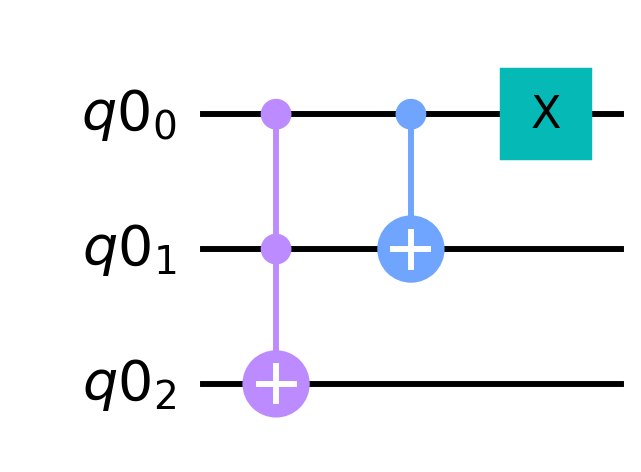

<Figure size 720x576 with 0 Axes>

In [18]:
N = 3
qreg = QuantumRegister(N)
incCirc = QuantumCircuit(qreg)
controls = [x for x in range(N-1)]

for p in range(N-1):
    target = controls[-1] + 1
    incCirc.mcx(controls,target)
    controls.pop()
    
incCirc.x(0)
display(incCirc.draw(output='mpl',style=style))
plt.clf()

Para implementar estas CNOTS arbitrariamente controladas, usamos a funçao mcx do Qiskit. 

Esta funçao fornece varias maneiras de decompor a CNOT, e a que usamos é baseada no facto de que uma operaçao unitaria pode ser implementada como sequencias de CNOTS simples e portas de um qubit, utilizando Gray Codes. 

Mais detalhes podem ser vistos no paper do Mottonen e na pagina 191 do livro do Nielsen e Chuang.

A escolha foi feita pois esta decomposiçao nao necessita de qubits auxiliares, diminuindo dos recursos utilizados.

Analisando o ciclo for, diminuimos o numero de controlos com a funçao pop a cada iteração, e consequentemente o numero de targets, resultando assim na cascata de CNOTS.

Esta porta X ao fim é uma pequena correçao ao modelo do Douglas e Wang, porque quando temos o estado 00, por exemplo, as CNOTS nao atuam, mas queremos que este estado seja incrementado para 01.

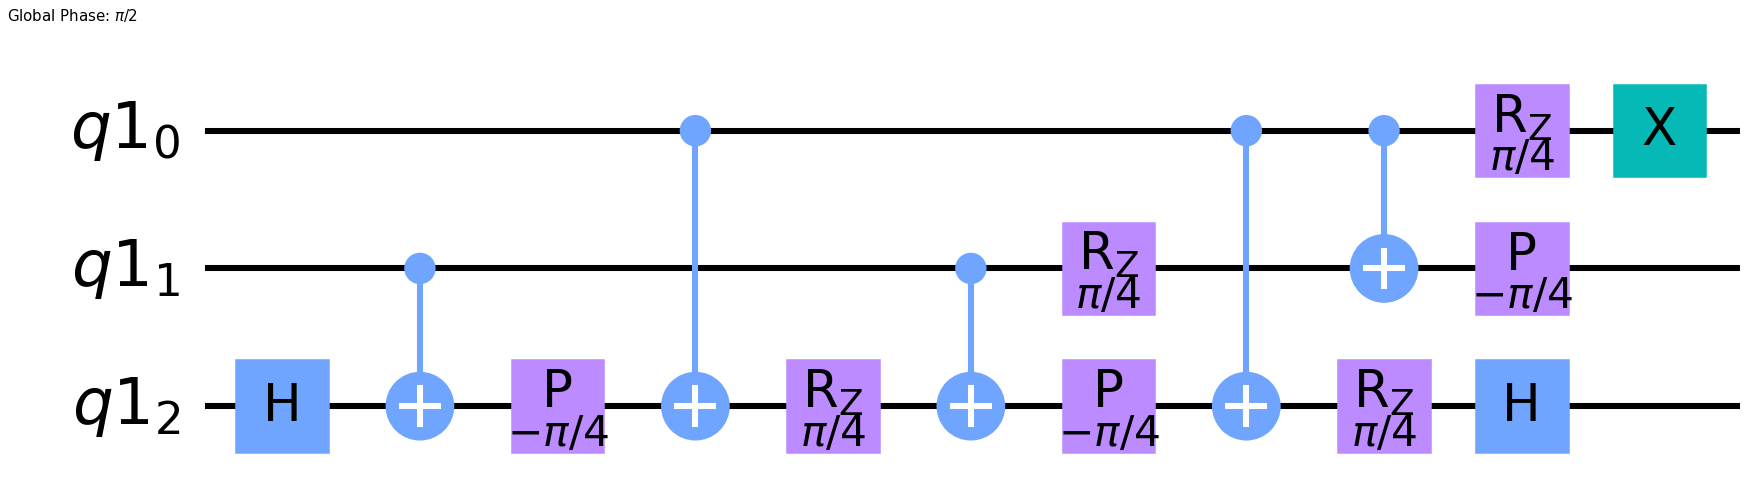

<Figure size 720x576 with 0 Axes>

In [19]:
N = 3
qreg = QuantumRegister(N)
incCirc2 = QuantumCircuit(qreg)
controls = [x for x in range(N-1)]

for p in range(N-1):
    incCirc2.mcx(controls,controls[-1]+1)
    controls.pop()
incCirc2.x(0)

incCirc2 = transpile(incCirc2,basis_gates=['cx','rz','x','p','h'])
display(incCirc2.draw(output='mpl',style=styleWide))
plt.clf()

And the decrement gate will simply be the same with it's controls negated.

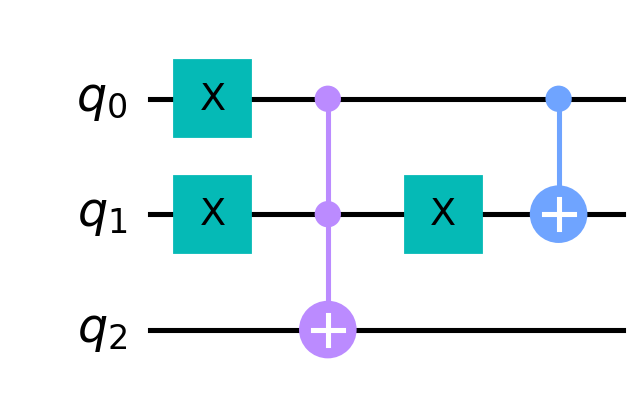

<Figure size 720x576 with 0 Axes>

In [20]:
N =3
decCirc = QuantumCircuit(N)
controls = [x for x in range(N-1)]
decCirc.x(controls)

for p in range(N-2):
    decCirc.mcx(controls,controls[-1] + 1)
    decCirc.x(controls[-1])
    controls.pop()
    
decCirc.cx(0,1)
display(decCirc.draw(output='mpl',style=style))
plt.clf()

O decremento sera igual, mas com os controlos negados.

Agora nao temos a porta X ao fim pois foi simplificada pelo Qiskit com outra porta X.

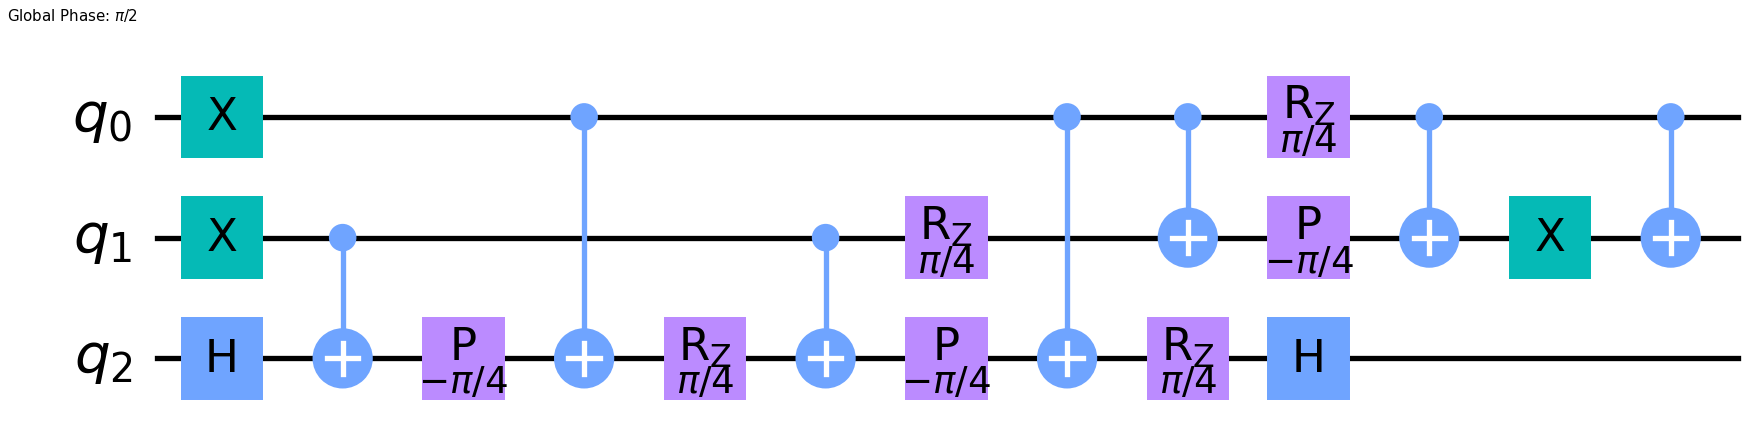

<Figure size 720x576 with 0 Axes>

In [21]:
N =3
decCirc = QuantumCircuit(N)
controls = [x for x in range(N-1)]
decCirc.x(controls)

for p in range(N-2):
    decCirc.mcx(controls,controls[-1] + 1)
    decCirc.x(controls[-1])
    controls.pop()
    
decCirc.cx(0,1)
decCirc = transpile(decCirc,basis_gates=['cx','rz','x','p','h'])
display(decCirc.draw(output='mpl',style=styleWide))
plt.clf()

Now that we have all the operations required to perform the walk, let's see the probability distributions that result from running this circuit multiple times with initial condition $\ket{\psi(0)} = \ket{0}\ket{x=4}$ and the Hadamard coin.\par
The full circuit will be

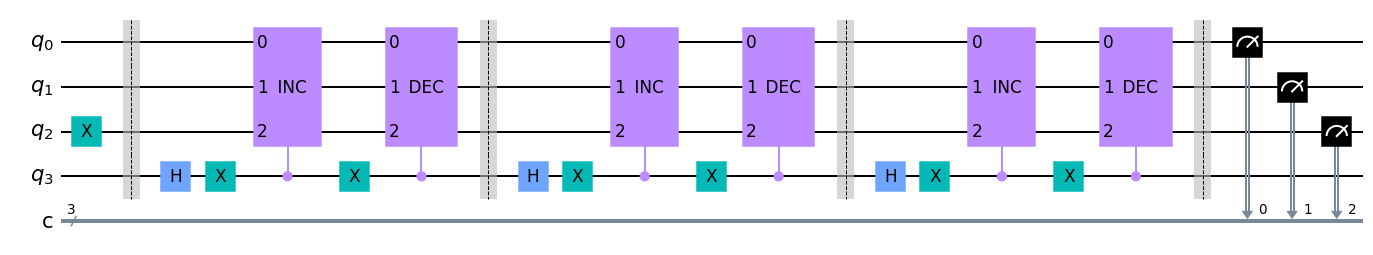

<Figure size 1800x319.332 with 0 Axes>

In [23]:
N = 3
steps = 3
initString = '001'
walkCirc = runCoinedWalk(N,steps,initString)
display(walkCirc.draw(output='mpl',style=styleWide,fold=-1))
plt.clf()

Consideramos então a caminhada com a moeda a começar no estado 0 e o walker na posiçao 4, correspondente ao centro do grafo.

Como podemos ver, para que o estado inicial do walker seja 4, temos que por uma porta X no 3º qubit, uma vez que este é o mais significativo devido à notação little-endian do Qiskit.

Temos entao o overview geral do circuito para 3 passos.

Let's now analyze if the probability distribution for each step makes sense.

The initial state is

\begin{equation}
	\ket{\Psi(0)} = \ket{0}\ket{4}
\end{equation}

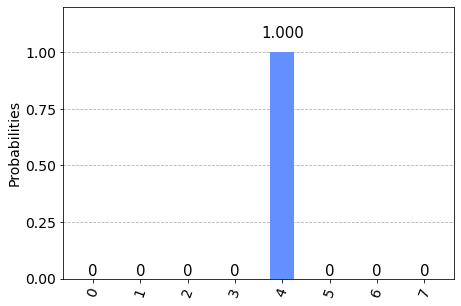

<Figure size 720x576 with 0 Axes>

In [22]:
N= 3
steps = 0
shots = 5000
initString = '001'
walkCirc = runCoinedWalk(N,steps,initString)
results = resultsSim(N,walkCirc,shots,True)
display(plot_histogram(results))
plt.clf()

Vamos entao analisar as amplitudes do estado passo a passo, para conferir que a nossa caminhada está correta.

Inicialmente, antes de aplicarmos moeda e shift, o caminhante esta na posiçao 4.

Since we defined the increment gate to act when coin state is $\ket{0}$, the state after the first step is

\begin{equation}
    \ket{\psi(1)} = U \ket{\psi(0)} = \frac{\ket{0}\ket{x=3}}{\sqrt{2}}+\frac{\ket{1}\ket{x=5}}{\sqrt{2}} \\\\
\end{equation}

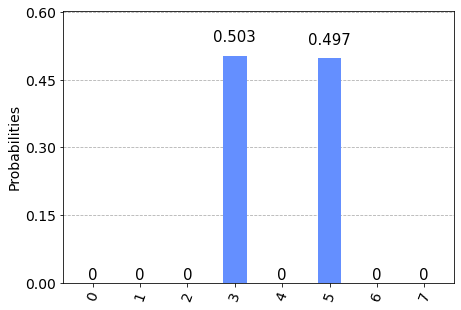

<Figure size 720x576 with 0 Axes>

In [23]:
N = 3
steps = 1
shots = 5000

initString = '001'
walkCirc = runCoinedWalk(N,steps,initString)
results = resultsSim(N,walkCirc,shots,True)
display(plot_histogram(results))
plt.clf()

Após a primeira iteração, podemos ver pela equaçao de onda que ambos estados terao igual amplitude. 

A distribuiçao de probabilidade está de acordo, dentro do erro experimental do Qiskit.

Moving on to the second iteration

\begin{equation}
    \ket{\Psi(2)} = \frac{\ket{0}\ket{x=2}}{2}+\frac{(\ket{1}+\ket{0})\ket{x=4}}{2}-\frac{\ket{1}\ket{x=6}}{2}\\\\
\end{equation}

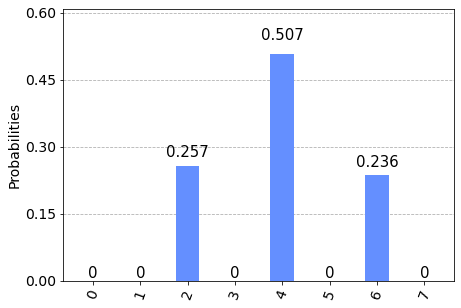

<Figure size 504x360 with 0 Axes>

In [26]:
N= 3
steps = 2
shots = 5000

initString = '001'
walkCirc = runCoinedWalk(N,steps,initString)
results = resultsSim(N,walkCirc,shots,True)
display(plot_histogram(results))
plt.clf()

Para 2 passos, vemos que o estado 4 tem contribuiçao de 2 faces da moeda, logo terá o dobro da probabilidade em comparação aos outros estados.

Note-se que até aqui, a caminhada quantica apresenta os mesmo resultados que uma clássica.


And finally, the third step

\begin{equation}
    \ket{\Psi(3)} = \frac{\ket{0}\ket{1}}{2\sqrt{2}}+\frac{(\ket{1}+2\ket{0})\ket{5}}{2\sqrt{2}} - \frac{\ket{0}\ket{3}}{2\sqrt{2}}+\frac{\ket{1}\ket{7}}{2\sqrt{2}}
\end{equation}


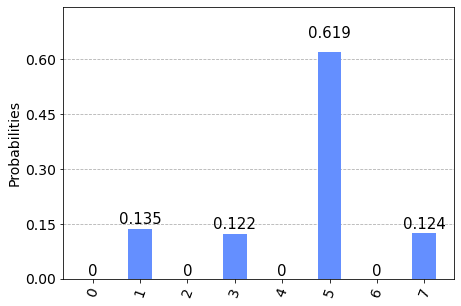

<Figure size 720x576 with 0 Axes>

In [24]:
N= 3
steps = 3
shots = 5000

initString = '001'
walkCirc = runCoinedWalk(N,steps,initString)
results = resultsSim(N,walkCirc,shots,True)
display(plot_histogram(results))
plt.clf()

The first $2$ steps of the walk are not unlike the classical walk. In fact, if we were to measure the state after each application, interference between states would not happen and we would just have a normal distribution.\par
However, when the quantum walk is allowed to proceed without intermediary measurements, the quantum effects become very apparent, as can be seen by state $\psi(3)$. Even though a balanced coined was used, this state is not symmetric nor centered around the origin.

No entanto, se deixarmos a caminhada evoluir durante 3 passos, vemos que esta diverge, apresentando aqui um desvio para a direita de acordo com o que vimos na simulaçao. 

Se medissemos os estados entre cada passo, nao existiria interferencia e a caminhada seria igual à clássica. 

As amplitudes correspondem a 5/8 de probabilidade para o estado 5, e 1/8 para os restantes. 

Se fizessemos a moeda começar no estado 1, veriamos que os 5/8 estariam no 3.

To remove this bias, the following initial condition was defined

\begin{equation}
        \ket{\Psi(0)} = \frac{\ket{0}+i\ket{1}}{\sqrt{2}}\ket{x=0}.
\end{equation}

This can be implemented in Qiskit by applying the Hadamard gate to the coin, followed by an S gate defined by

\begin{equation}
S = \begin{pmatrix} 1 & 0 \\ 0 & i \end{pmatrix}
\end{equation}


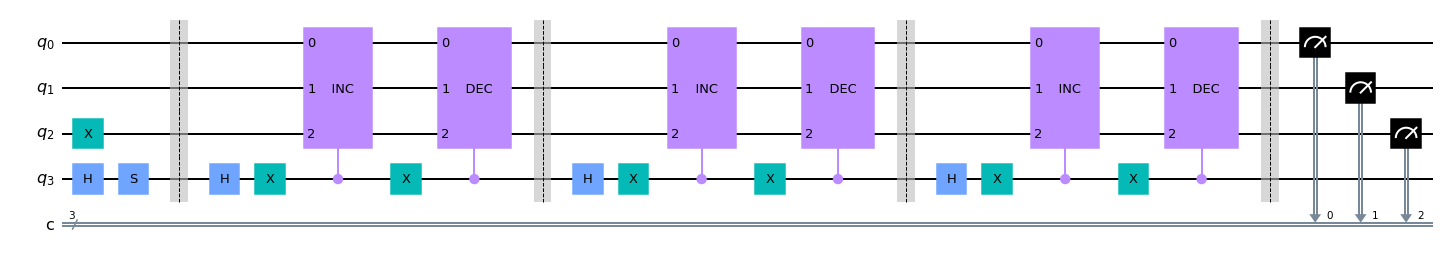

<Figure size 1892.6x325.08 with 0 Axes>

In [29]:
N= 3
steps = 3

initString = '001'
walkCirc = runCoinedWalkSup(N,steps,initString)
display(walkCirc.draw(output='mpl',fold=-1))
plt.clf()

Finalmente, para obtermos uma caminhada simétrica, basta introduzirmos a porta S após a aplicação da Hadamard na moeda, de modo a obtermos a condição inicial da equação 18.


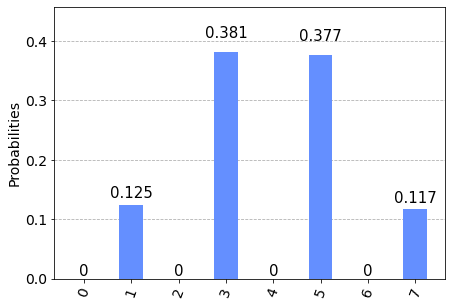

<Figure size 720x576 with 0 Axes>

In [28]:
N= 3
steps = 3
shots = 5000

initString = '001'
walkCirc = runCoinedWalkSup(N,steps,initString)
results = resultsSim(N,walkCirc,shots,True)
display(plot_histogram(results))
plt.clf()

We see now that instead of drifting towards state $\ket{5}$, the walk will now be symmetric.

Fazendo as mediçoes, vemos que em vez de termos uma tendencia para a direita ou para a esquerda, temos uma igual probabilidade do caminhante estar no 3 ou no 5, novamente  de acordo com a simulaçao. 

Isto indica que construimos o circuito correto para esta caminhada.


<center> <h2> Continuous-time Quantum Walk </h2> </center>

Vamos agora ver um modelo alternativo para uma caminhada quantica, onde o tempo é continuo.

In [29]:
def circulantAdjacency(n,v):
    iv = list(range(0,n))
    av = list(range(0,n-1))
    C = np.zeros([n,n])
    for z in range(n):
        C[z,0] = v[iv[z]]    
    for x in range(1,n):
        av = iv[0:-1]
        iv[0] = iv[-1]
        iv[1::] = av
        for y in range(0,n):
            C[y,x] = v[iv[y]]
    return C

def initStateCont(N,initCond): #generalizar isto ?
    psi0 = np.zeros((N,1))
    for x in initCond:
        psi0[x] = 1 / len(initCond)
    return psi0

def final_state(Op,psi0):
    psiN = Op.dot(psi0)
    return psiN

def ct_evo(H,t,gamma):
    U = linalg.expm(-1j*gamma*H*t)
    return U

def prob_vec(psiN,N):
    probs = np.zeros((N,1))
    for x in range(N):
        probs[x]=psiN[x]*np.conjugate(psiN[x]) 
    return probs

def ctqwalk(N, A, t, gamma, initState):
    psi0 = initState
    U = ct_evo(A,t,gamma)
    psiN = final_state(U,psi0)
    probvec = prob_vec(psiN,N)
    return probvec

The Continuous-time Random Walk is an alternative model of a random walk, firstly introduced by \cite{montrollweiss1965}, which does not require a coin. Because time is continuous, the walker can transition from some position $x_i$ to another $x_j$ at any time.

One way to visualize the dynamics is to imagine the probability of the walker transitioning as a fluid that is trickling from position $x_i$ to $x_j$. The probability of it being found in $x_i$ gradually shifts to $x_j$, until the walker eventually moves ahead. The increase and decrease of the probability can be described by a transition rate, $\gamma$, which is constant for all vertices and times.

Classicamente, a Caminhada Continua no Tempo, introduzida pelo Waters e Herbert, é um modelo que nao necessita de uma moeda.

Como o tempo é continuo, o caminhante tem uma probabilidade de transitar de um estado para o outro a qualquer momento.

Podemos imaginar a probabilidade neste modelo como um fluido que escoa da posiçao xi para xj. 

Gradualmente a probabilidade diminui num vertice e aumenta noutro, até que o caminhante transita, quantificado pela taxa de transiçao gamma.

In order to deal with the continuous variables, we must setup an appropriate differential equation and find it's solutions

\begin{equation}
	\frac{dp(x,t)}{dt} = \gamma L p(x,t), \label{contWalk}
\end{equation}

where $L$ is the Laplacian defined as $L = A - D$.

$A$ is the adjacency matrix that represents each vertex connection, given by

\begin{equation}
	A_{ij} = \begin{cases} 1, & \mbox{if } (i,j)\in G \\ 0, & \mbox{otherwise,} \end{cases}
\end{equation}

and D is the diagonal matrix $D_{jj} = deg(j)$ that represents how many neighbors each vertex has.

Para descrevermos um sistema continuo no tempo, precisamos de uma equaçao diferencial que nos diga como é que a probabilidade varia no tempo e no grafo. 

Do lado direito da equação 20 temos o Laplaciano, que nos permite discretizar o grafo.

Temos que o Laplaciano é igual a A - D, onde A e a matriz de adjacencia e D a matriz de grau.

A matriz de adjacencia diz-nos quais vertices são vizinhos, e a matriz de grau diz-nos quantos vizinhos cada vertice tem.

In the quantum case, we have the Continuous-time Quantum Walk (CTQW) \cite{fahri98}. The vertices now are quantum states that form the basis for the Hilbert space, which means the vector that describes the probability distribution must be converted to a state vector. The transition matrix must also be converted to an equivalent unitary operator. What is left is the following Schrödinger equation

\begin{equation}
	i\hbar \frac{d\ket{\Psi(x,t)}}{dt} = H \ket{\Psi(x,t)}, \label{shrodinger}
\end{equation}

where $H = -\gamma L$.

Solving the equation results in the evolution operator

\begin{equation}
	U(t) = e^{-iHt} = e^{i(-\gamma L)t} = e^{-i\gamma(A+D)t},
    \label{eq:continuousEvolution}
\end{equation}

considering $\hbar = 1$.

For a regular graph, $A$ and $D$ commute. This means that the evolution operator can be written in terms of the adjacency matrix, since the degree will be the identity matrix multiplied by some constant making it a global phase

\begin{equation}
	U(t) = e^{-i\gamma A t + i\gamma D t} = e^{-i\gamma A t} e^{i\gamma D t} = \phi(t) e^{-i\gamma A t}.
\end{equation}

Consideramos agora o caso da caminhada quantica continua no tempo, introduzida pelo Fahri e Gutmann.

Fazendo a conversao da equaçao diferencial anterior, obtemos a equaçao de Shrodinger 22. 

O Hamiltoniano será descrito pela taxa de transição multiplicada pelo Laplaciano, e terá que ser unitário.

Resolvendo a equaçao diferencial, resulta no operador da equação 23, considerando a constante de planck modificada 1.

Para um grafo regular, em que todos os vertices tem o mesmo grau, A e D comutam, pelo que podemos reescrever o operador como a multiplicaçao de 2 exponenciais de acordo com a equação 24.

Como a matriz de grau será apenas a matriz de identidade multiplicada por uma constante, esta será uma fase global, podendo ser ignorada.

In this example we will study the CTQW on a cycle, whose adjacency matrix can be traditionally defined by

\begin{equation}
    A = \sum_{x} \ket{x+1}\bra{x} + \ket{x}\bra{x+1}
\end{equation}

However, this can be seen as an instance of a broader class of graphs, namely \textit{circulant graphs}. This kind of graph is defined by a circulant matrix

\begin{equation}\label{eq:adjc}
A = 
\begin{bmatrix}
c_0&c_{N-1}& \cdots&c_2&c_1 \\
c_1&c_0& c_{N-1}& &c_{2} \\
\vdots & c_1 & c_0 &\ddots & \vdots\\
c_{N-2}& & \ddots&\ddots &c_{N-1}\\
c_{N-1} & c_{N-2} & \cdots & c_1 & c_0\\
\end{bmatrix}.
\end{equation}


Considering a simple cycle graph, the adjacency matrix should have some constraints. The first one is $c_0 = 0$ by the absence of self-loops. Secondly, we must have a symmetric matrix, and the constraint should be $c_{n-j}=c_j$.

Neste exemplo vamos considerar novamente o ciclo, cuja matriz de adjacencia é descrita pela equação 25.

No entanto, podemos considerar isto na perspetiva de grafos circulantes. 

Esta classe de grafos é descrita pela matriz da equação 26, em que a proxima coluna resulta da permutacao ciclica dos elementos da coluna anterior.

Impomos tambem restriçoes na matriz:
1. a diagonal terá que ser 0 porque nao permitimos autoloops
2. e Cn-j será igual a Cj, para que a matriz seja simétrica e Hermitiana.

We can define the circulant matrix based on the first column vector and an operation, similar to a deque, where we move every element to the following position in a cyclic fashion. Therefore, we have the first column vector as

\begin{equation}
    v_1 = [c_0,c_1,\cdots,c_{N-2}, c_{N-1}]^T
\end{equation}

and the deque operation such that

\begin{equation}
    D v_1 =[c_{N-1},c_0,\cdots,c_{N-3}, c_{N-2}]^T = v_2
\end{equation}

In [30]:
N = 5
cCycle = [0,1] + [0 for x in range(N-3)] + [1]
A = circulantAdjacency(N,cCycle)  
print(A)

[[0. 1. 0. 0. 1.]
 [1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1.]
 [1. 0. 0. 1. 0.]]


Esta matriz pode ser descrita pela sua primeira coluna e uma operaçao deque, que poe o ultimo elemento na primeira posiçao, e desloca todos os outros para a posiçao seguinte.

A matriz de adjacencia resultante é essencialmente a matriz do shift do caso discreto, mas sem o espaço da moeda.

Now that we have the adjacency matrix, the unitary evolution operator

\begin{equation}
 U(t) = e^{-i\gamma A t}
\end{equation}

can be implemented as

In [84]:
N = 5
cCycle = [0,1] + [0 for x in range(N-3)] + [1] 
A = circulantAdjacency(N,cCycle)

gamma = 1/2*np.sqrt(2)
t = 1
U = linalg.expm(-1j*gamma*A*t)
print(U.round(2))

[[ 0.56-0.j    0.01-0.54j -0.21+0.05j -0.21+0.05j  0.01-0.54j]
 [ 0.01-0.54j  0.56-0.j    0.01-0.54j -0.21+0.05j -0.21+0.05j]
 [-0.21+0.05j  0.01-0.54j  0.56-0.j    0.01-0.54j -0.21+0.05j]
 [-0.21+0.05j -0.21+0.05j  0.01-0.54j  0.56-0.j    0.01-0.54j]
 [ 0.01-0.54j -0.21+0.05j -0.21+0.05j  0.01-0.54j  0.56-0.j  ]]


O operador de evolução será dado pelo exponencial da matriz de adjacencia, multiplicada por gamma e tempo.

Mais à frente, iremos ver como descrever este operador com a sua decomposição espectral, que é mais rápido computacionalmente.

Se o tempo for 0, o exponencial será simplesmente 1, pelo que temos a matriz identidade.

À medida que avançamos o tempo, isto muda.

Meaning that the state of our walk after time $t$ is

\begin{equation}
	\ket{\Psi(t)} = U(t)\ket{\Psi(0)},
\end{equation}

where 

\begin{equation}
	\ket{\Psi(0)} = \ket{0}.
\end{equation}


In [39]:
N = 5
cCycle = [0,1] + [0 for x in range(N-3)] + [1] 
A = circulantAdjacency(N,cCycle)
gamma = 1/2*np.sqrt(2)
t = 0.5
U = linalg.expm(-1j*gamma*A*t)

N=5
psi0 = initStateCont(N,[2])
psiN = U.dot(psi0)
print(psiN.round(2))

[[-0.06+0.01j]
 [ 0.  -0.33j]
 [ 0.88-0.j  ]
 [ 0.  -0.33j]
 [-0.06+0.01j]]


O nosso estado final será entao descrito por uma unica aplicaçao do operador ao estado inicial.

No caso anterior o tempo surgia da aplicaçao sucessiva de operadores de evoluçao, agora a noçao de tempo está imbutida diretamente no operador.

Transforming the amplitudes in probabilities

In [89]:
N = 5
cCycle = [0,1] + [0 for x in range(N-3)] + [1] 
A = circulantAdjacency(N,cCycle)
gamma = 1/2*np.sqrt(2)
t = 1
U = linalg.expm(-1j*gamma*A*t)

psi0 = initStateCont(N,[2])
psiN = U.dot(psi0)

probs = np.zeros((N,1))
for x in range(N):
    probs[x]=psiN[x]*np.conjugate(psiN[x]) 
print(probs.round(3))

[[0.047]
 [0.297]
 [0.313]
 [0.297]
 [0.047]]


Analisando as probabilidades resultantes do estado final, vemos que em vez de termos uma transiçao abrupta do estado inicial para os estados adjacentes, temos uma transferencia gradual da probabilidade por todo o grafo.

Putting it all together in the _ctqwalk_ function (available in this notebook) allows us to plot the probability distribution. \par
For this example we consider a CQW, at $t=100$, on cyclic graph with 200 vertices, and $\gamma = \frac{1}{2\sqrt{2}}$.

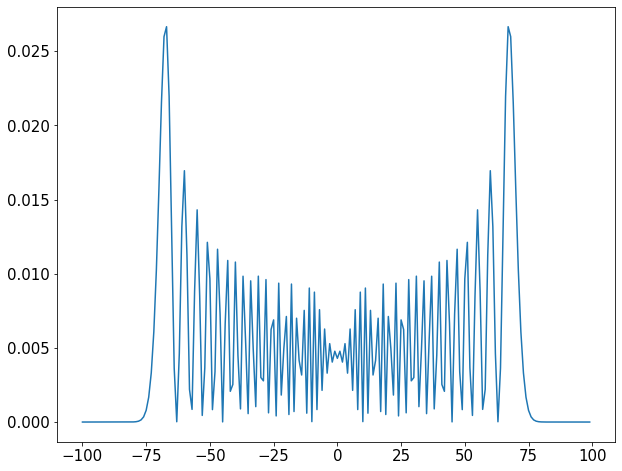

In [41]:
N = 200
t=100
cCycle = [0,1] + [0 for x in range(N-3)] + [1]
gamma = 1/(2*np.sqrt(2))
A = circulantAdjacency(N,cCycle)
initCond = [int(N/2)]
initState = initStateCont(N,initCond)
qw = ctqwalk(N,A,t,gamma,initState)

plt.plot(np.arange(-N/2,N/2),qw)

A distribuiçao de probabilidade após um maior intervalo de tempo revela que mesmo para o estado inicial 0, esta caminhada é simétrica. 

Isto acontece porque agora nao temos uma moeda a introduzir uma tendencia para um dos lados, e nenhum dos operadores presentes na caminhada apresenta alguma preferência.

The choice of initial condition also has an effect on the probability distribution. For example, if

\begin{equation}
	\ket{\Psi(0)} = \frac{\ket{0}+\ket{1}}{\sqrt{2}}
\end{equation}

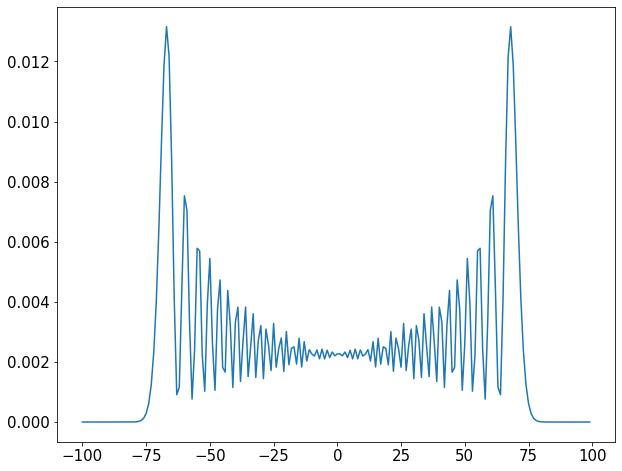

In [42]:
N = 200
t=100
cCycle = [0,1] + [0 for x in range(N-3)] + [1]
denom = 2
gamma = 1/(denom*np.sqrt(2))
A = circulantAdjacency(N,cCycle)
initCond = [int(N/2),int(N/2)+1]
initState = initStateCont(N,initCond)
qw = ctqwalk(N,A,t,gamma,initState)

plt.plot(np.arange(-N/2,N/2),qw)

Alterando a condiçao inicial para uma sobreposiçao entre os estados 0 e 1, vemos um formato semelhante. 

Continuamos a ter dois picos longe da origem, mas menos amplitude nos estados intermédios.

In both initial conditions we can see several similarities to the probability distribution of the coined quantum walk model. Both have two peaks away from the origin and low probability near the origin. 

<center>
<img src="ctqwMultipleTimeSuperposition.png" width="800" height="600"/>

In the discrete-time model changing the coin's initial condition would impact both shape and propagation of the walk. However, in the continuous-time model, modifying the transition rate (or time) does influence the propagation, but not the overall pattern. Changing the initial condition of the walker does change the probability distribution but the peaks remain symmetric.

Vemos algumas semelhanças ao caso simetrico do modelo discreto, devido a existirem dois picos longe da origem.

No entanto, no caso discreto, a utilizaçao de uma moeda introduzia potencialmente tendencias e para alterar o formato geral tinhamos que alterar os parametros da moeda.

No caso continuo, alterar o parametro gamma ou condição inicial, por exemplo, leva a uma modificacao da dispersao da caminhada, mas nao o formato geral. 

In [43]:
%%HTML
<center>
<video width="810" height="570" controls>
  <source src="ContQuantumWalk.mp4" type="video/mp4">
</video>

Novamente os picos circulam o grafo, interferindo um com o outro levando à uniformizaçao da distribuiçao.

<center> <h2> Qiskit Implementation </h2> </center>

Vamos agora reformular o algoritmo, de modo a que seja possivel gerar circuitos do Qiskit para este.

In [45]:
def circulant_adjacency(n,v): #--- it computes an adjacency matrix for the circulant graph
    iv = list(range(0,n))
    av = list(range(0,n-1))
    C = np.zeros([n,n])
    for z in range(n):
        C[z,0] = v[iv[z]]
    for x in range(1,n):
        av = iv[0:-1]
        iv[0] = iv[-1]
        iv[1::] = av
        for y in range(0,n):
            C[y,x] = v[iv[y]]
    return C

def unitary_ctqw(gamma, N, A,t): #---
    U = expm(1j*(-gamma*A)*t)
    return U

def diagUniOp(N,diagU0):
    qreg = QuantumRegister(N)
    creg = ClassicalRegister(N)
    circ = QuantumCircuit(qreg,name='    UniOp    ')
    circ.diagonal(diagU0,qreg) 
    circ = transpile(circ)#,optimization_level=3)#,backend=backend,layout_method=method) 
    return circ

def runContCirc(N,diagUniOp,t):
    qreg = QuantumRegister(N)
    creg = ClassicalRegister(N)
    circ = QuantumCircuit(qreg,creg)
    if t == 0: 
        circ.x(qreg[0])
        circ.measure(qreg,creg)
        circ = transpile(circ)
        return circ 
    else:
        circ.x(qreg[0])
        circ.barrier()
        circ.append(QFT(N,do_swaps=False,approximation_degree=0,inverse=True,name='    QFT    '),range(N))
        circ.barrier()
        circ.append(diagUniOp,range(N))
        circ.barrier()
        circ.append(QFT(N,do_swaps=False,approximation_degree=0,inverse=False,name='    IQFT'    ),range(N))
        circ.barrier()
        circ.measure(qreg,creg)
        circ=transpile(circ,basis_gates=['cx','cp','rz','h','x'])
    return circ


def multDiagUniOp(N,NCirc,gamma,adjacency,time,backend,method):
    unitaryCircList = []
    for t in time:
        U0 = unitary_ctqw(gamma,N,adjacency,[],t)
        diagU0 = np.diag(U0).tolist()
        diagCirc = diagUniOp(NCirc,diagU0,backend,method)
        unitaryCircList.append(diagCirc)
    return unitaryCircList


def multContCirc(N,unitaryList,time,backend,methods):
    circList = []
    circListAux = []
    qreg = QuantumRegister(N)
    qsub = QuantumRegister(1)
    creg = ClassicalRegister(N)
    for t,diagU0 in zip(time,unitaryList):
        circ = QuantumCircuit(qreg,creg)
        circ =  contCirc(N,diagU0,backend,method,t)
        circ = transpile(circ,optimization_level=3,backend=backend, layout_method=method)
        circList.append(circ)
    return circList

def drawCircCont(N,diagU,time,style):
    qreg = QuantumRegister(N,name='qv')
    creg = ClassicalRegister(N)
    circ = QuantumCircuit(qreg,creg)
    circ.x(qreg[0])
    circ.barrier()
    circ.append(QFT(N,do_swaps=False,approximation_degree=0,inverse=False,name='    QFT    '),range(N))
    circ.append(diagU,range(N))
    circ.append(QFT(N,do_swaps=False,approximation_degree=0,inverse=True,name='    IQFT    '),range(N))
    circ.barrier()
    circ.measure(qreg,creg)
    fig = circ.draw(output='mpl',style=style)
    return fig 

def drawQftCirc(N,style):
    qreg = QuantumRegister(N)
    creg = ClassicalRegister(N)
    circ = QuantumCircuit(qreg,creg)
    circ = QFT(N,do_swaps=False,approximation_degree=0,inverse=False,name='    QFT    ')
    circ = transpile(circ, basis_gates=['cp','h','cx','rz'])
    fig = circ.draw(output='mpl',style=style)
    return fig 

def drawDiagUni(N,diagU0,backend,method,style):
    qreg = QuantumRegister(N)
    creg = ClassicalRegister(N)
    circ = QuantumCircuit(qreg,name='    UniOp    ')
    circ.diagonal(diagU0,qreg) 
    circ = transpile(circ,basis_gates=['cp','h','cx','rz'])
    fig = circ.draw(output='mpl',style=style)
    return fig
    
def runContWalk(N,NCirc,t,gamma,c):
    qft = dft(N, scale = 'sqrtn')
    iqft = inv(qft)
    A = iqft@circulant_adjacency(N,c)@qft
    U0 = unitary_ctqw(gamma, N, A,t)
    diagU0 = np.diag(U0).tolist()
    UCirc = diagUniOp(NCirc,diagU0)
    cCirc = runContCirc(NCirc,UCirc,t)
    return cCirc

def resultsSimCont(N,circ,shots,Decimal):
    "Returns the dictionary produced by QASM simulator with the MSB changed to convention, and values (previously frequencies) converted to probabilities."
    result = simul(circ,False,shots)
    baseDict = baseResultDict(N,Decimal)
    if Decimal:
        correctedResultAux = { int(k[::-1],2) : v/shots for k, v in result.items()}
    else:
        correctedResultAux = { k[::-1] : v/shots for k, v in result.items()}
    correctedResult = normalizedResultDict(baseDict,correctedResultAux)
    return correctedResult

The eigenvalues of circulant matrices can be found by

\begin{equation}
\lambda_p = c_0 + \sum_{q=1} c_{N-q} \omega^{pq},
\end{equation}


considering $\omega^{pq} = e^{2\pi i/N}$.

And the associated eigenvectors by

\begin{equation}
\ket{\varphi_p} = \frac{1}{\sqrt{n}} \sum_{q=0}^{n-1} \omega^{pq} \ket{q}
\end{equation}

Os valores proprios de uma matriz circulante sao conhecidos e podem ser calculados pela equaçao 33.

Os vetores proprios associados serao calculados como na eq 34, e serão as nossas bases de Fourier.

This is relevant, because it is possible to construct an operator that diagonalizes the circulant matrix through the eigenvectors. For this purpose, we can use the \textit{Quantum Fourier Transform} (QFT) that is defined as

\begin{equation}
F = \frac{1}{\sqrt{N}} \sum_{p,q} \omega^{pq} \ket{p}\bra{q},
\end{equation}

and rewrite the adjacency matrix as 

\begin{equation}
    A = F^{\dagger} \Lambda F \implies \Lambda = F A F^{\dagger} 
    \label{eq:circAdjMatrix},
\end{equation}

where $\Lambda$ is a diagonal operator which encodes the eigenvalues as

\begin{equation}
\Lambda = \sum_{j} \lambda_j \ket{j}\bra{j}.
\end{equation}

Considering the cycle graph case

In [46]:
N = 4
qft = dft(N, scale = 'sqrtn')
iqft = inv(qft)
cCycle = [0,1] + [0 for x in range(N-3)] + [1]
A = circulant_adjacency(N,cCycle)

lambdA = iqft@A@qft
print(lambdA.round(2))

[[ 2.+0.j -0.-0.j  0.-0.j  0.-0.j]
 [ 0.+0.j -0.-0.j -0.-0.j -0.+0.j]
 [ 0.+0.j -0.+0.j -2.+0.j  0.+0.j]
 [ 0.+0.j  0.-0.j  0.+0.j -0.-0.j]]


Isto é relevante, pois podemos usar a transformada de Fourier quantica para diagonalizar A.

A matriz de adjacencia pode ser entao reescrita como na eq 36, onde o lambda é um operador diagonal que codifica os valores proprios.

Numericamente lambda poderá ser calculado aplicando fourier a A.

The unitary operator of the walk can then be rewritten as

\begin{equation}\label{eq:diagUniOpCont}
    U(t) =  e^{i\gamma F^{\dagger} \Lambda F t}  =F^{\dagger} e^{i\gamma \Lambda t} F,
\end{equation}

where

\begin{equation}
    e^{i\gamma \Lambda t} = \sum_{j} e^{i\gamma \lambda_j t} \ket{j}\bra{j}.
\end{equation}

In [47]:
gamma = 1/(2*np.sqrt(2))
t=1
U0 = expm(1j*(-gamma*lambdA)*t)
print(U0.round(2))

[[ 0.76-0.65j -0.  +0.j   -0.  -0.j   -0.  -0.j  ]
 [ 0.  -0.j    1.  +0.j   -0.  -0.j    0.  +0.j  ]
 [-0.  -0.j    0.  +0.j    0.76+0.65j  0.  -0.j  ]
 [-0.  -0.j   -0.  -0.j    0.  -0.j    1.  +0.j  ]]


Substituindo isto no operador de evoluçao, podemos reescreve-lo como na eq 38. 

Note-se que podemos retirar F do exponencial, por causa do teorema de decomposiçao espectral.


Because the evolution operator is now a diagonal matrix, we can use the Qiskit function \textit{diagonal}, which takes the diagonal entries of a matrix and converts them into a circuit based on the following decomposition presented in \cite{Shende06}.

<center>
<img src="diagDecomposition.png" width="1000" height="800"/>

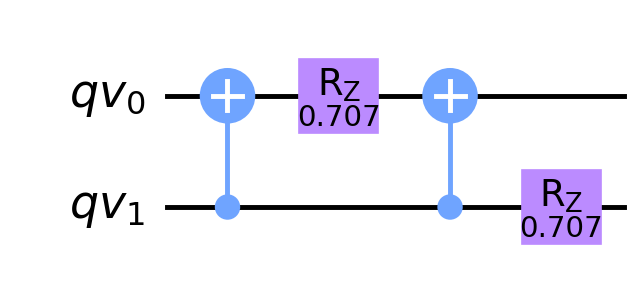

<Figure size 720x576 with 0 Axes>

In [48]:
NCirc = 2
qreg = QuantumRegister(NCirc,name='qv')

evoOp = QuantumCircuit(qreg, name='     U     ')
U = np.diag(U0).tolist()
evoOp.diagonal(U,qreg)
evoOp = transpile(evoOp,basis_gates=['cp','h','cx','rz'])   
display(evoOp.draw(output='mpl',style=style))
plt.clf()

Como temos agora um operador diagonal, podemos usar a funçao diagonal do Qiskit, baseada na decomposiçao apresentada no artigo do shende, como podemos ver na figura abaixo. 

Nao vou entrar em detalhe porque vai para alem do ambito desta apresentaçao.

O circuito do operador de evoluçao diagonal para um caso pequeno será entao o seguinte.

The final component is the QFT, whose general circuit is

<center>
<img src="qftcirc.png" width="1000" height="800"/>

where 

\begin{equation}
	R_k = \begin{pmatrix}
		&1 & 0 & \\
		&0 & e^{\frac{2\pi i}{2^k}}
              \end{pmatrix}.
\end{equation}

\cite{chagassantos21}

O ultimo componente sera a QFT, descrita por este circuito.

O Qiskit da-nos a oportunidade de aproximar este circuito, uma vez que quanto maior for k , menos signficativa será a rotaçao, sendo assim possivel poupar recursos a custo de alguma precisao.

Estudamos o impacto das diferentes aproximaçoes de Fourier no artigo citado, onde comparamos a fidelidade de circuitos para diversos grafos, nos computadores da IBM.

In Qiskit, the QFT circuit for $2$ qubits will look like

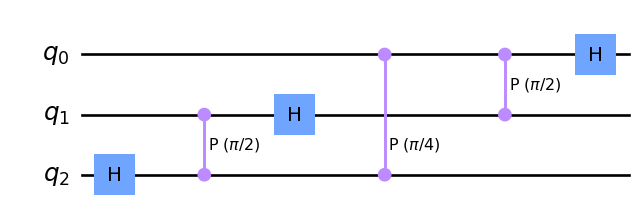

<Figure size 720x576 with 0 Axes>

In [47]:
NQft = 3
qreg = QuantumRegister(NQft,name='qv')
qftCirc = QuantumCircuit(qreg) 

qftCirc = QFT(NQft,do_swaps=False,approximation_degree=0,inverse=False,name='    QFT    ')
qftCirc = transpile(qftCirc, basis_gates=['h','cx','rz','cp'])
display(qftCirc.draw(output='mpl',style=style))
plt.clf()

O circuito da transformada de Fourier no Qiskit é entao o seguinte.

Putting it all together, the overall circuit in Qiskit will be

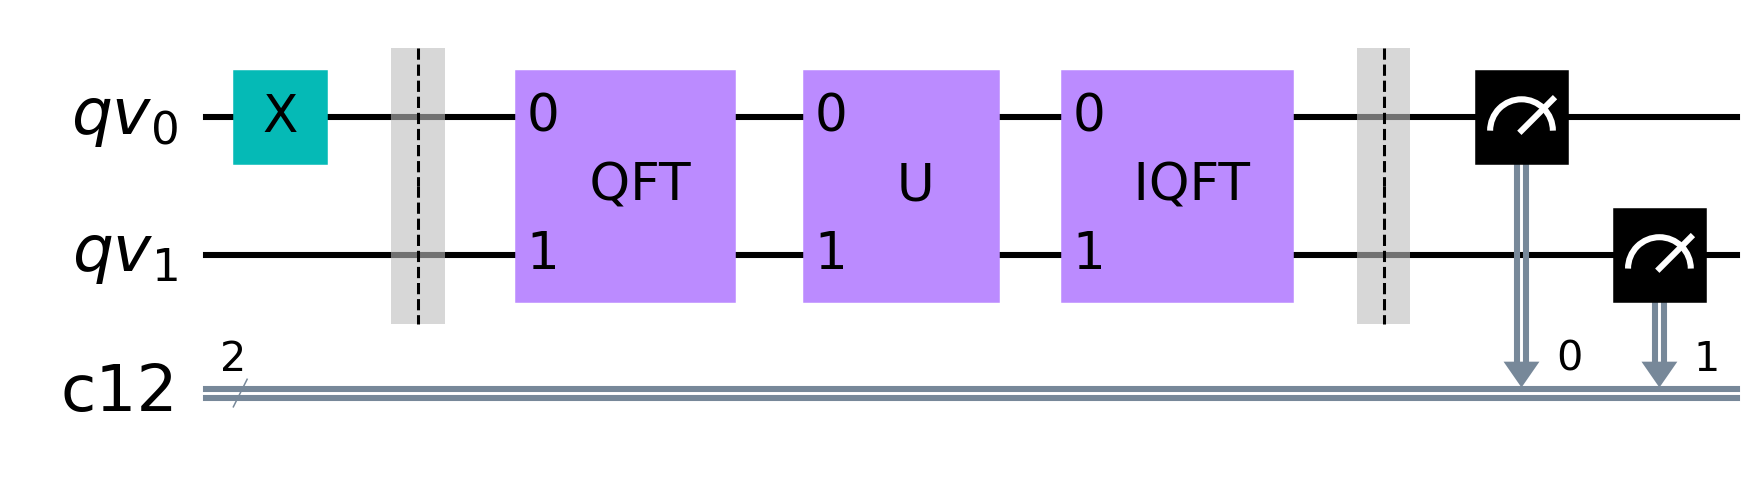

<Figure size 720x576 with 0 Axes>

In [90]:
NCirc = 2
gamma =  1/(2*np.sqrt(2))
t = 1
continuousCirc = drawCircCont(NCirc,evoOp,t,styleWide) 

display(continuousCirc)
plt.clf()

Sendo o circuito completo para a caminhada descrito como na figura.

To visualize the probability distribution, let's consider the cycle graph again but with $16$ vertices or $N=4$ qubits. For the initial condition $\psi(0) = \ket{8}$, the walk at $t=0$ will result in the following distribution.

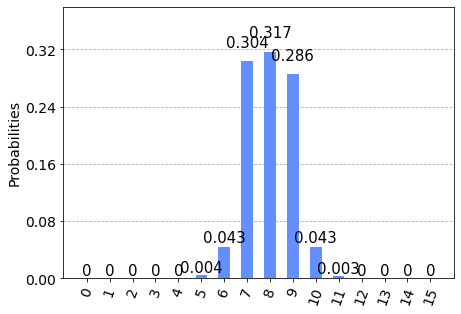

<Figure size 720x576 with 0 Axes>

In [97]:
NCont = 16
NCircCont = 4
gamma =  1/(2*np.sqrt(2))
tCont = 2
cCycle = [0,1] + [0 for x in range(NCont-3)] + [1]
shotsCont = 5000

contCirc = runContWalk(NCont,NCircCont,tCont,gamma,cCycle)
resultCont = resultsSimCont(NCircCont,contCirc,shotsCont,True) 
display(plot_histogram(resultCont))
plt.clf()

Para 4 qubits, podemos ver que este circuito realmente corresponde à CTQW. 

Evoluindo o estado a começar no 8 vemos que as probabilidades escoam gradualmente para os vertices vizinhos.

<center> <h2> Search Problems </h2> </center>

Vamos agora ver alguns problemas de busca no qiskit, e como podemos usar a CTQW para encontrar um elemento em tempo otimo.

<center> <h3> Grover's algorithm </h3> </center>

In [50]:
def markedListGrover(markedList,N):
    oracleList = np.ones(2**N)
    for element in markedList:
        oracleList[element] = -1
    return oracleList.tolist()

def getOracleGrover(markedList,N):
    oracleList = np.eye(2**N)
    for element in markedList:
        oracleList[element][element] = -1
    return oracleList

def oracleGrover(marked,N):
    markedList = markedListGrover(marked,N)
    qreg = QuantumRegister(N)
    qc = QuantumCircuit(qreg,name='    Oracle    ')
    qc.diagonal(markedList,qreg)
    qc=transpile(qc,optimization_level=3)
    return qc

def diffusionGrover(N):
    qreg = QuantumRegister(N)
    difCirc = QuantumCircuit(qreg,name='     Diff    ')
    difCirc.h(qreg)
    qcAux = oracleGrover([0],N)
    difCirc.append(qcAux,range(N))
    difCirc.h(qreg)
    difCirc=transpile(difCirc,optimization_level=3)
    return difCirc

def runGrover(N,steps,marked):
    qc = QuantumCircuit(N,N)
    qcOracle = oracleGrover(marked,N)
    qcDiffusion = diffusionGrover(N)
    qc.h(range(N))
    for i in range(steps):
        qc.append(qcOracle,range(N))
        qc.barrier()
        qc.append(qcDiffusion,range(N))
        qc.barrier()
    qc.barrier()
    qc.measure(range(N),range(N))
    qc = transpile(qc,optimization_level=1)
    return qc

def drawGroverCirc(N,steps,marked,style):
    qc = QuantumCircuit(N,N)
    qcOracle = oracleGrover(markedListGrover(marked,N),N)
    qcDiffusion = diffusionGrover(N)
    qc.h(range(N))
    qc.barrier()
    for i in range(steps):
        qc.append(qcOracle,range(N))
        qc.append(qcDiffusion,range(N))
        qc.barrier()
    qc.measure(range(N),range(N))
    qc = transpile(qc)
    fig = qc.draw(output='mpl',style=style)
    return qc

def drawOracle(N,marked,style):
    qreg = QuantumRegister(N)
    qc = QuantumCircuit(qreg,name='    Oracle    ')
    qc.diagonal(markedListGrover(marked,N),qreg)
    qc=transpile(qc,basis_gates=['cx','rz','ccx','x','h'])
    fig = qc.draw(output='mpl',style=style)
    return fig 

def drawDiffusion(N,style):
    qreg = QuantumRegister(N)
    difCirc = QuantumCircuit(qreg,name='     Diff    ')
    difCirc.h(qreg)
    aux = markedListGrover([0],N)
    qcAux = oracleGrover(aux,N)
    difCirc.append(qcAux,range(N))
    difCirc.h(qreg)
    difCirc=transpile(difCirc,basis_gates=['cx','rz','ccx','x','h'])
    fig = difCirc.draw(output='mpl',style=style)
    return fig

def drawCircGrover(N,steps,marked,style):
    qc = QuantumCircuit(N,N)
    qcOracle = oracleGrover(marked,N)
    qcDiffusion = diffusionGrover(N)
    qc.h(range(N))
    qc.barrier()
    for i in range(steps):
        qc.append(qcOracle,range(N))
        qc.append(qcDiffusion,range(N))
        qc.barrier()
    qc.measure(range(N),range(N))
    qc = transpile(qc)
    fig = qc.draw(output='mpl',style=style)
    return qc

def resultsSimGrover(N,circ,shots,Decimal):
    "Returns the dictionary produced by QASM simulator with the MSB changed to convention, and values (previously frequencies) converted to probabilities."
    result = simul(circ,False,shots)
    baseDict = baseResultDict(N,Decimal)
    if Decimal:
        correctedResultAux = { int(k,2) : v/shots for k, v in result.items()}
    else:
        correctedResultAux = { k : v/shots for k, v in result.items()}
    correctedResult = normalizedResultDict(baseDict,correctedResultAux)
    return correctedResult

Grover's algorithm is a quantum alternative to unstructured search problems. Consider the case of finding element $x_0$ in an unordered list of size $N$. On average, a classical algorithm needs around $\frac{N}{2}$ steps, and $N$ steps in the worst case.

Grover's algorithm accomplishes the same in $O(\sqrt{N})$, as was shown by \cite{grover1996}.

The algorithm is as follows
\begin{enumerate}
\item Prepare state $\ket{\Psi_0}  = \frac{1}{\sqrt{N}}\sum_{x=0}^{N-1} \ket{x}$;
\item Mark the solution elements with the oracle operator $\mathcal{O} = I - 2\sum_{m\in M} \ket{m}\bra{m}$;
\item Amplitude amplification process with the diffusion operator $ \mathcal{D} = (2\ket{\Psi_0}\bra{\Psi_0} - I) = H^{\otimes n}(2\ket{0}\bra{0} - I)H^{\otimes n}$;
\item Apply operator $U = \mathcal{O} \mathcal{D}$,  $O(\sqrt{N})$ times for maximum amplitude of the marked vertex.
\item Measure the state.
\end{enumerate}


O Grover é um algoritmo de busca em estruturas sem ordem. 

No caso classico, no pior dos casos teriamos que percorrer todos os N elementos para encontrar a soluçao, ou N/2 em media.

O Grover, em contrapartida, promete alcançar o mesmo em O(sqrt(N)) sendo possivelmente um ganho quadratico em relaçao ao caso classico.

O procedimento é entao o seguinte
1. Começamos num estado inicial de sobreposiçao.
2. Marcamos os estados da soluçao com o oraculo, onde M é o conjunto dos elementos marcados.
3. Fazemos a amplificaçao de amplitude, com uso do operador de Difusao.
4. Aplicamos estes operadores O(sqrt(N)) vezes.
5. Medimos o estado resultante.

Considering the case where we have $3$ qubits ($N=8$) and one marked element, the optimal number of steps is $\frac{\pi}{4}\sqrt{N} \approx 2$, and the corresponding circuit will be

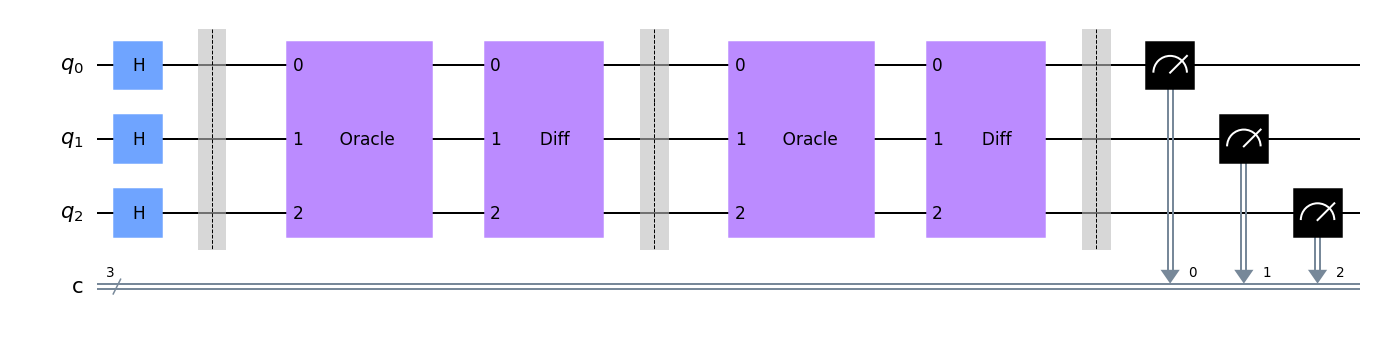

In [49]:
NGrover = 3
stepsGrover = int(ceil((np.pi /4)* (np.sqrt(N))))
markedGrover = [4]
groverCirc = drawCircGrover(NGrover,stepsGrover,markedGrover,styleWide)

Para o caso de 3 qubits, e 1 elemento marcado, o numero otimo de passos é aproximadamente 2. 

O circuito geral será entao o seguinte.


The oracle operator is a diagonal matrix

\begin{equation}
	\mathcal{O} = I - 2\sum_{m\in M} \ket{m}\bra{m} =
	\begin{pmatrix}
		(-1)^{f(0)} & 0 & \cdots & 0\\
	        0 & (-1)^{f(1)} & \cdots & 0\\ 
	        \vdots & 0 &  \ddots & \vdots\\ 
		0 & 0 & \cdots &  (-1)^{f(N-1)}
	\end{pmatrix}.
	\label{eq:oracleMatrixQiskit}
\end{equation}

where $f(x) = 1$ if $x \in M$, otherwise 0.

O oraculo é uma matriz diagonal, onde f(x) = 1 se x for uma soluçao, ou 0 caso contrario.

Podemos ver que quando f(x) dá zero, o elemento da diagonal tem sinal positivo, e se f(x) der 1, temos o sinal negativo, assinalando assim o elemento marcado.

In [52]:
NGrover = 3
markedGrover = [4]
oracleMatrixGrover = np.eye(2**NGrover)

for element in markedGrover:
    oracleMatrixGrover[element][element] = -1
print(oracleMatrixGrover)

[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]]


We can use the \textit{diagonal} function to generate the circuit

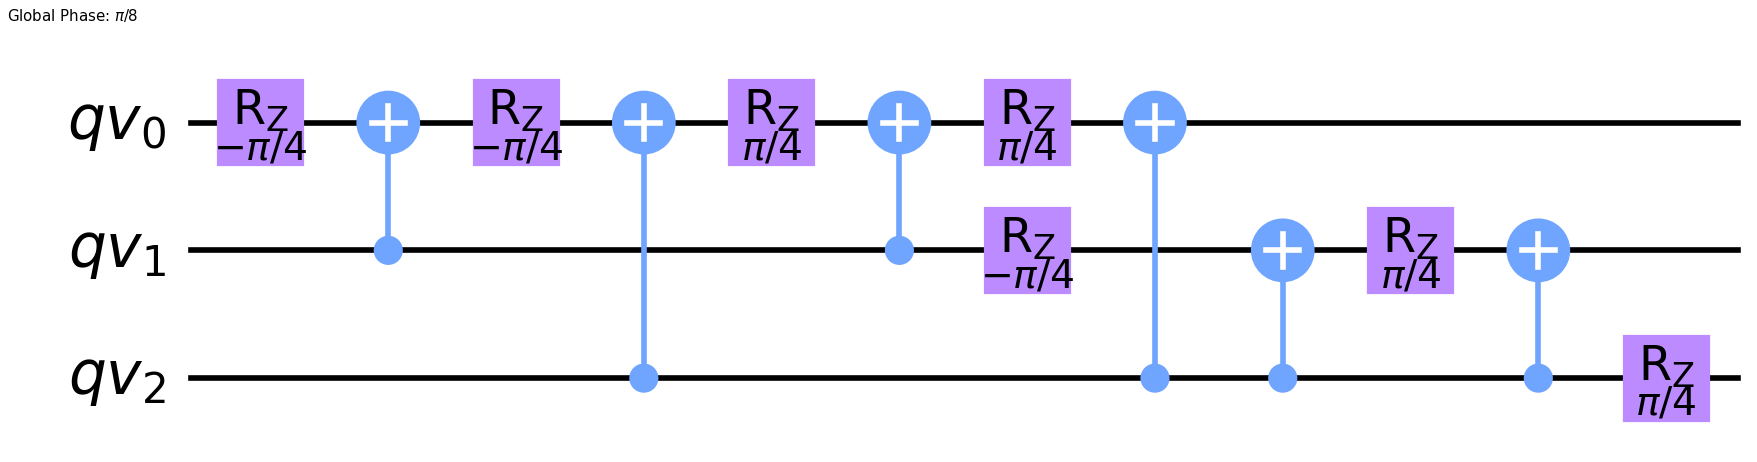

<Figure size 720x576 with 0 Axes>

In [53]:
NGrover = 3
diagOracle = np.diag(oracleMatrixGrover).tolist()
qreg = QuantumRegister(NGrover,name='qv')
qcOracle = QuantumCircuit(qreg)

qcOracle.diagonal(diagOracle,qreg)
qcOracle = transpile(qcOracle,basis_gates=['cx','rz'])
display(qcOracle.draw(output='mpl',style=styleWide))
plt.clf()

Desta maneira, podemos usar a funçao diagonal para gerar o seguinte circuito para o oraculo.

As we saw, the diffusion operator is

\begin{equation}
        \mathcal{D} = H^{\otimes n}(2\ket{0}\bra{0} - I)H^{\otimes n}.
\end{equation}

In order to implement this circuit, this definition is very useful since it tells us the diffusion operator is simply an inverted oracle with Hadarmad gates before and after the operation.

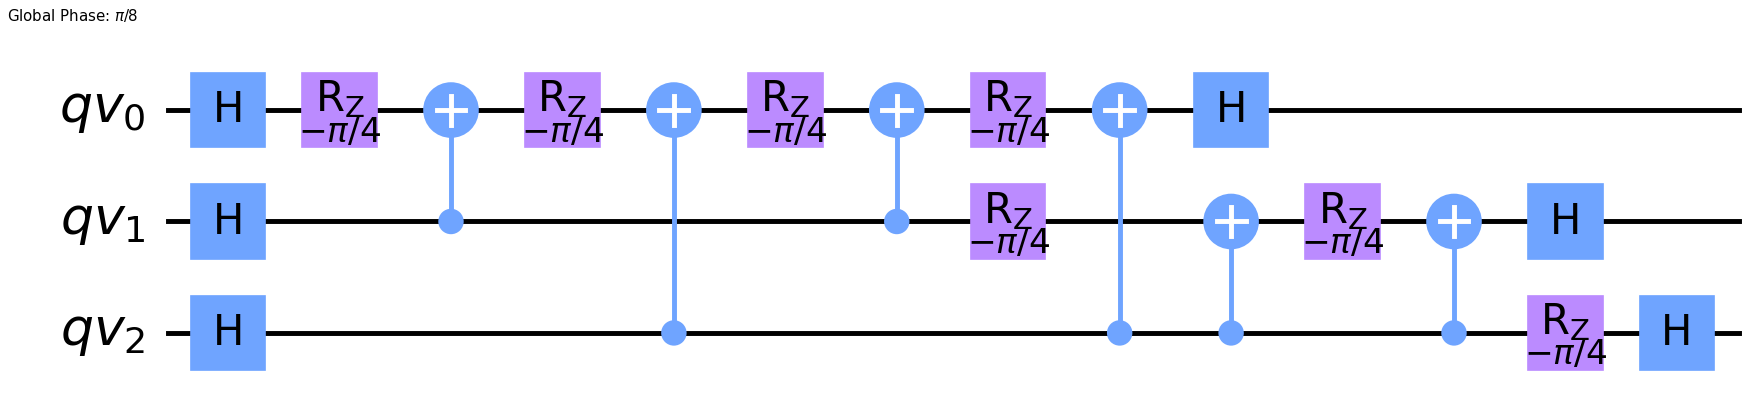

<Figure size 720x576 with 0 Axes>

In [54]:
NGrover = 3
qreg = QuantumRegister(NGrover,name='qv')
qcDiffusion = QuantumCircuit(qreg)
oracleAux = oracleGrover([0],NGrover)

qcDiffusion.h(qreg)
qcDiffusion.append(oracleAux,range(NGrover))
qcDiffusion.h(qreg)
qcDiffusion = transpile(qcDiffusion,basis_gates=['cx','rz','h'])
display(qcDiffusion.draw(output='mpl',style=styleWide))
plt.clf()

O operador de difusao, como vemos na equaçao 42, pode ser descrito como o oraculo para o elemento 0, rodeado de portas Hadamard, sendo implementado de forma equivalente no qiskit.

Putting it all together, the probability distribution for one marked element after $3$ steps is

Steps = 3


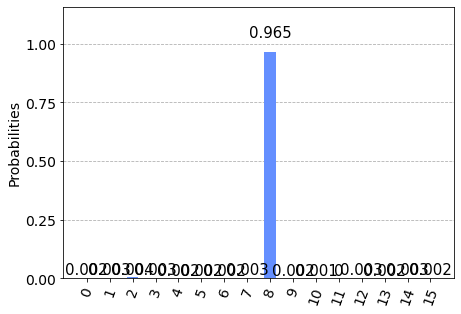

<Figure size 720x576 with 0 Axes>

In [104]:
NGrover = 4
offset = 0
steps = floor((np.pi /4)* (np.sqrt(2**NGrover))) + offset
print(f"Steps = {steps}")
markedGrover = [8]
shots = 5000

groverCirc = runGrover(NGrover,steps,markedGrover)
resultsGrover = resultsSimGrover(NGrover,groverCirc,shots,True)
display(plot_histogram(resultsGrover))
plt.clf()

Correndo entao o circuito para o estado marcado 8, temos a seguinte distribuiçao de probabilidades para 3 passos.

Este é realmente o numero otimo de passos, uma vez que se fizermos mais ou menos 1, a probabilidade do elemento marcado nao será tao elevada.

A probabilidade nao é exatamente igual a 1, pois o numero de passos está arredondado devido ao natureza discreta do algoritmo.

Considering more than one marked element, say $K$ solutions for the searching problem, the optimum number of iterations is

\begin{equation}
	 \frac{\pi}{4}\sqrt{\frac{N}{K}}
\end{equation}

as was shown by \cite{boyer1996}. 

For a $16$ element search space, it is expected that a $2$ marked element search requires $\frac{\pi}{4}\sqrt{\frac{16}{2}} \approx 2$ steps.

Steps=2


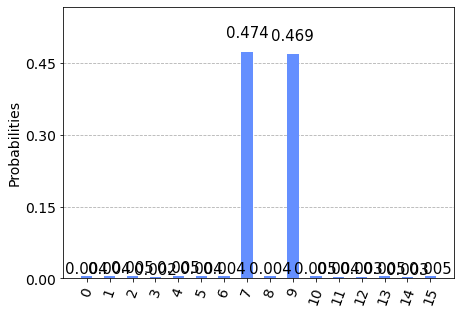

<Figure size 720x576 with 0 Axes>

In [55]:
NGrover = 4
steps = floor((np.pi/4) * np.sqrt(2**NGrover/2))   # = 2
print(f"Steps={steps}")
markedGrover = [7,9]
shots = 5000
groverCirc = runGrover(NGrover,steps,markedGrover)
resultsGrover = resultsSimGrover(NGrover,groverCirc,shots,True)
display(plot_histogram(resultsGrover))
plt.clf()

Na verdade, o numero otimo de passos depende do numero de soluçoes. 

Por exemplo, para 1 soluçao e 16 elementos, seriam necessarios 3 passos. 

Se fizermos o calculo para 2 soluçoes, vemos que o numero otimo de passos será 2.

An interesting case is when the number of marked elements represents $\frac{1}{4}$ of the total elements. This is usually called \textit{single-shot} Grover's algorithm since 

\begin{equation}
 	 \frac{\pi}{4} \sqrt{ \frac{N}{\frac{N}{4}} } = \frac{\pi}{4}\sqrt{\frac{N}{4N}} = \frac{\pi}{4}\frac{1}{2} \approx 1
\end{equation}

which means that a single iteration of the circuit is optimum regardless of the size of the search space, when one fourth of the elements are solutions.

Steps=1


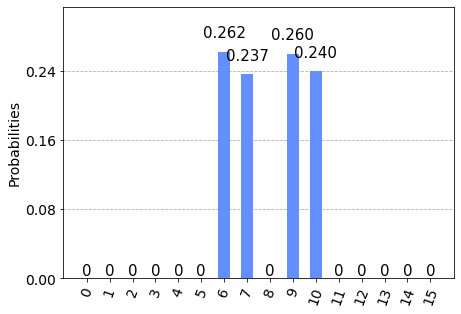

<Figure size 720x576 with 0 Axes>

In [89]:
NGrover = 4
steps = floor((np.pi/4) * np.sqrt(2**NGrover/4)) # = 1
print(f"Steps={steps}")
markedGrover = [6,7,9,10]
shots = 5000

groverCirc = runGrover(NGrover,steps,markedGrover)
resultsGrover = resultsSimGrover(NGrover,groverCirc,shots,True)
display(plot_histogram(resultsGrover))
plt.clf()


Uma consequencia interessante disto, é quando o numero de elementos marcados corresponde a 1/4 do numero total de elementos, visto quer será apenas necessario 1 passo. 

Isto é chamado de single-shot grover.

<center> <h3> Continuous-time Quantum Walk </h3> </center>

The unitary evolution operator presented in equation \ref{eq:continuousEvolution} can be modified as to accomodate an oracle 

\begin{equation}
	U'(t) = e^{-iH't} = e^{-i\gamma (L + O)t}
\end{equation}

where $H' = -\gamma(L+O)$, $L = A-D$ and the oracle is defined as 

\begin{equation}
	O = \sum_{m \in M} \ket{m}\bra{m}.
\end{equation}

Vamos agora ver uma breve descriçao do problema de busca aplicado a uma caminhada continua no tempo.

Começamos por modificar o operador de evoliçao para acomodar o oraculo. Basta inserir este operador no  Hamiltoniano.

In this example, we consider a complete graph whose vertices are all adjacent to one another.

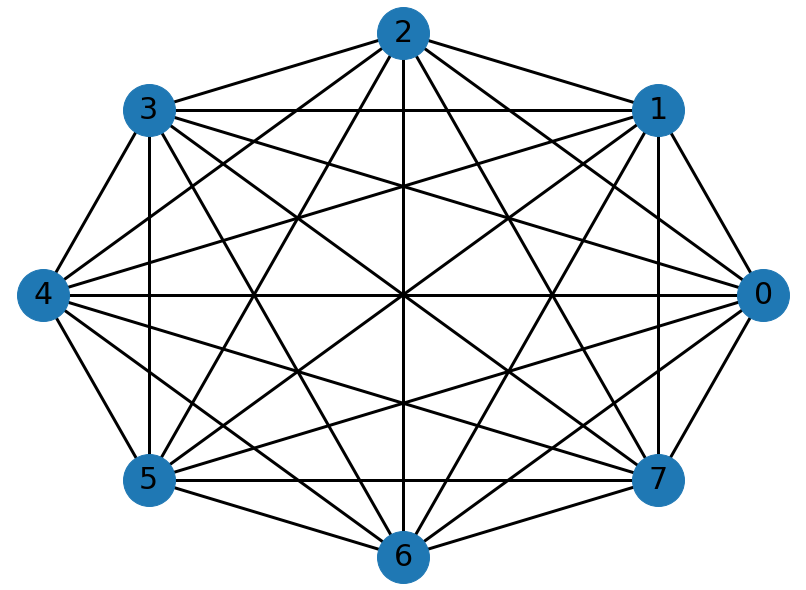

In [56]:
nx.draw_circular(GComplete, with_labels = True,node_size=2700,width=3,font_size=30)

This graph is also regular, which means that the adjacency matrix and degree matrix commute. Therefore, the unitary evolution operator will be

\begin{equation}
	U'(t) = e^{-i\gamma ((A-D) + O)t} = \phi(t) e^{-i\gamma(A+O)t} = e^{-i\gamma(A+O)t}
\end{equation}

Neste caso consideramos um grafo completo, em que todos os vertices estao ligados por arestas.

Como todos os vertices tem o mesmo grau, este grafo é regular, pelo que A e D comutam.

However, the adjacency matrix and oracle operator do not commute, which means we need to use the Suzuki-Trotter expansion

\begin{equation}
	e^{i(H_0+H_1)t}=\lim_{n \rightarrow \infty}(e^{i\frac{H_0t}{n}}e^{i\frac{H_1t}{n}})^n ,
\end{equation}

where $n$ is the Trotter number. 

The modified evolution operator can then be rewritten as

\begin{equation}
    U'(t) = e^{-i\gamma(A+O)t} = \lim_{n \rightarrow \infty}(e^{i\frac{At}{n}}e^{i\frac{\mathcal{O}t}{n}})^n
\end{equation}

No entanto, A e O nao comutam, pelo que temos de usar a formula de Suzuki-Trotter para decompor o operador de evoluçao. Este pode ser reescrito entao como a eq 49.

Isto é uma aproximaçao ditada pelo numero de Trotter.

Remember from equation \ref{eq:circAdjMatrix}

\begin{equation}\label{eq:diag_adj}
    A = F^{\dagger} \Lambda F,
\end{equation}

$U'(t)$ will become

\begin{equation}
	U'(t) =\lim_{n \rightarrow \infty}(F^{\dagger} e^{i\gamma\frac{\Lambda t}{n}} F e^{i\gamma\frac{Ot}{n}})^n .
	\label{eq:suzTrotter}
\end{equation}

This representation is useful, because it allows us to construct a circuit very directly.

<center>
<img src="contsearchcircuit.png" width="1000" height="800"/>

Since both the oracle and the modified evolution operator are diagonal matrices, they can be easily implemented in Qiskit using the diagonal function.

Recordando que A pode ser diagonalizada pela QFT, podemos reescrever U como na equaçao 51.

Esta representaçao é bastante util visto que nos permite escrever o circuito diretamente.

Como tanto o operador de evoluçao como o oraculo sao matrizes diagonais, podemos implementar facilmente em Qiskit.

Because we cannot apply the operations in the box an infinite number of times, our circuit will only be an approximation. However, for a circuit with $3$ qubits, a Trotter number of $2$ will be sufficient to guarantee the success of the search to a satisfactory degree.

<center>
<img src="ContQW_N3_S1.png" width="900" height="700"/>

This searching problem reaches maximum probability after $\frac{\pi}{2}\sqrt{N}$ steps, as was shown by \cite{janmark2014}. However, due to the Trotter approximation, our circuit will require more and more resources as the number of qubits increases, not only because the size of our search is larger but also because we need to apply more and more iterations of the search in order to get the probability as close to 1 as possible.

Como nao podemos usar um numero de Trotter infinito, este circuito é uma aproximaçao. Para um circuito com 3 qubits, por exemplo, 2 iteraçoes de Trotter sao suficientes para obter uma amplitude do elemento marcado em tempo otimo.

O numero teorico de passos é ligeiramente diferente do grover, como demonstrado pelo Janmark, mas continua na mesma ordem de grandeza, o que indica que estes algoritmos sao equivalentes e ótimos.

No entanto, esta necessidade de iteraçoes de Trotter aumenta os recursos consumidos, visto que quanto maior for o numero de elementos mais iteraçoes sao necessárias.

Uma análise que iremos fazer baseia-se no facto da QFT poder ser aproximada, e até completamente substituida por hadamards no caso do grafo completo. 

Um dos objetivos da investigaçao será descobrir o grau de aproximaçao da QFT que podemos usar para diferentes tipos de grafos, de modo a reduzir o numero de operaçoes utilizadas, e se realmente os computadores da IBM conseguem correr este algoritmo para um caso nao trivial.

# References

(<a id="cit-kpearson1905" href="#call-kpearson1905">Pearson, 1905</a>) Pearson Karl, ``_The Problem of the Random Walk_'', Nature, vol. 72, number 1865, pp. 294,  1905.  [online]()

(<a id="cit-cootner67" href="#call-cootner67">Cootner, 1967</a>) Paul H. Cootner, ``_The random character of stock market prices._'',  1967.

(<a id="cit-aharonov1993" href="#call-aharonov1993">Aharonov, Davidovich <em>et al.</em>, 1993</a>) Aharonov Y., Davidovich L. and Zagury N., ``_Quantum Random Walks_'', Physical Review A, vol. 48, number 2, pp. 1687-1690,  1993.  [online]()

(<a id="cit-nayak2000" href="#call-nayak2000">Nayak and Vishwanath, 2000</a>) Nayak Ashwin and Vishwanath Ashvin, ``_Quantum Walk on the Line_'', , vol. , number , pp. ,  2000.  [online]()

(<a id="cit-aharonov2002" href="#call-aharonov2002">Aharonov, Ambainis <em>et al.</em>, 2001</a>) Aharonov Dorit, Ambainis Andris, Kempe Julia <em>et al.</em>, ``_Quantum Walks on Graphs_'', STOC '01 Proceedings of the thirty-third annual ACM symposium on Theory of computing, vol. , number , pp. 50-59,  2001.  [online]()

(<a id="cit-inui2003" href="#call-inui2003">Inui, Konishi <em>et al.</em>, 2003</a>) Inui Norio, Konishi Yoshinao and Konno Norio, ``_Localization of Two-Dimensional Quantum Walks_'', Physical Review A, vol. 69, number 5, pp. 052323,  2003.  [online]()

(<a id="cit-shenvi2002" href="#call-shenvi2002">Shenvi, Kempe <em>et al.</em>, 2003</a>) Shenvi Neil, Kempe Julia and Whaley Birgitta, ``_A Quantum Random Walk Search Algorithm_'', Physical Review A, vol. 67, number 5, pp. 052307,  2003.  [online]()

(<a id="cit-lovett2010" href="#call-lovett2010">B., Cooper <em>et al.</em>, 2010</a>) B. Neil, Cooper Sally, Everett Matthew <em>et al.</em>, ``_Universal Quantum Computation Using the Discrete Quantum Walk_'', Physical Review A, vol. 81, number 4, pp. 042330,  2010.  [online]()

(<a id="cit-REN1" href="#call-REN1">Portugal, 2018</a>) Renato Portugal, ``_Quantum Walks and Search Algorithms_'',  2018.

(<a id="cit-childs2002" href="#call-childs2002">M., Cleve <em>et al.</em>, 2002</a>) M. Andrew, Cleve Richard, Deott Enrico <em>et al.</em>, ``_Exponential algorithmic speedup by quantum walk_'', Proc. 35th ACM Symposium on Theory of Computing (STOC 2003), pp. 59-68, vol. , number , pp. ,  2002.  [online]()

(<a id="cit-ambainis2003" href="#call-ambainis2003">Ambainis, 2007</a>) Ambainis Andris, ``_Quantum Walk Algorithm for Element Distinctness_'', SIAM Journal on Computing, vol. 37, number 1, pp. 210-239,  2007.  [online]()

(<a id="cit-childs2004" href="#call-childs2004">M. and Goldstone, 2004</a>) M. Andrew and Goldstone Jeffrey, ``_Spatial Search by Quantum Walk_'', Physical Review A, vol. 70, number 2, pp. 022314,  2004.  [online]()

(<a id="cit-douglaswang07" href="#call-douglaswang07">Douglas and B., 2009</a>) Douglas B.L. and B. J., ``_Efficient quantum circuit implementation of quantum walks_'', , vol. , number , pp. ,  2009.

(<a id="cit-mikko2004" href="#call-mikko2004">Mottonen, Vartiainen <em>et al.</em>, 2004</a>) Mottonen Mikko, Vartiainen Juha J., Bergholm Ville <em>et al.</em>, ``_Quantum Circuits for General Multiqubit Gates_'', Physical Review Letters, vol. 93, number 13, pp. , Sep 2004.  [online](http://dx.doi.org/10.1103/PhysRevLett.93.130502)

(<a id="cit-nielsen2011" href="#call-nielsen2011">A. and L., 2011</a>) Michael A. and Isaac L., ``_Quantum Computation and Quantum Information: 10th Anniversary Edition_'',  2011.

(<a id="cit-montrollweiss1965" href="#call-montrollweiss1965">Waters and Herbert, 1997</a>) Waters Elliott and Herbert George, ``_Random walks on lattices. II_'', Journal of Mathematical Physics, vol. , number , pp. 167–181,  1997.  [online]()

(<a id="cit-fahri98" href="#call-fahri98">Farhi and Gutmann, 1998</a>) Farhi Edward and Gutmann Sam, ``_Quantum Computation and Decision Trees_'', Physical Review A, 58:915-928, vol. , number , pp. ,  1998.  [online]()

(<a id="cit-Shende06" href="#call-Shende06">Shende, Bullock <em>et al.</em>, 2006</a>) Shende V.V., Bullock S.S. and Markov I.L., ``_Synthesis of quantum-logic circuits_'', IEEE Transactions on Computer-Aided Design of Integrated Circuits and Systems, vol. 25, number 6, pp. 1000–1010, Jun 2006.  [online](http://dx.doi.org/10.1109/TCAD.2005.855930)

(<a id="cit-grover1996" href="#call-grover1996">K., 1996</a>) K. Lov, ``_A Fast Quantum Mechanical Algorithm for Database Search_'', STOC '96 Proceedings of the twenty-eighth annual ACM symposium on Theory of computing, vol. , number , pp. 212-219,  1996.  [online]()

(<a id="cit-boyer1996" href="#call-boyer1996">Boyer, Brassard <em>et al.</em>, 1998</a>) Boyer Michael, Brassard Gilles, Høyer Peter <em>et al.</em>, ``_Tight Bounds on Quantum Searching_'', Fortschritte der Physik, vol. 46, number 4-5, pp. 493-505,  1998.  [online]()

(<a id="cit-janmark2014" href="#call-janmark2014">Janmark, Meyer <em>et al.</em>, 2014</a>) Janmark Jonatan, Meyer David A. and Wong Thomas G., ``_Global Symmetry is Unnecessary for Fast Quantum Search_'', Physical Review Letters, vol. 112, number 21, pp. , May 2014.  [online](http://dx.doi.org/10.1103/PhysRevLett.112.210502)

